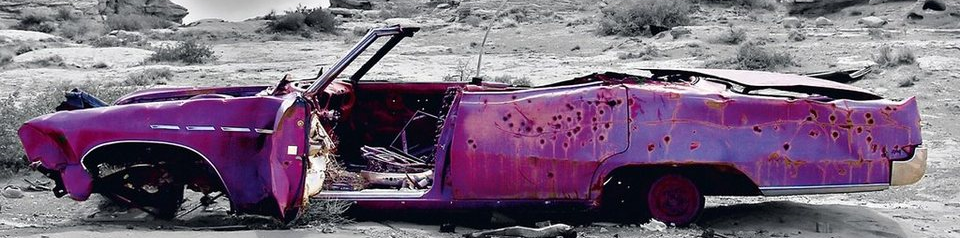

# Определение стоимости автомобилей

**Цель работы:**

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.\
В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости.
Заказчику важны: качество предсказания; скорость предсказания; время обучения.

Признаки в датасете:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя\
Целевой признак <br>
- `Price` — цена (евро)


**План работы:**

* загрузить данные и изучить их (пропуски, дубликаты);
* анализ данных (гистограммы, распределение);
* взаимосвязь данных;
* кодирование, масштабирование;
* линейная модель, лес решений, бустинговые модели.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from catboost import Pool, cv
import lightgbm as lgb

In [2]:
try:
    data = pd.read_csv('../../15 численные методы/project/autos.csv')
except:
    try:
        data = pd.read_csv('/datasets/autos.csv')
    except:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [3]:
data.head(3)

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# количество и доля пропусков
gaps_0 = pd.DataFrame(data.isna().sum(), columns=['sum']).join(
         pd.DataFrame(data.isna().mean(), columns=['share']))
gaps_0.style.format({'sum':'{:.0f}','share':'{:.2f}'}).background_gradient('YlGn')

In [6]:
data.isna().sum().sum() # общее количество пропусков

181077

In [7]:
data.describe()         # описание числовых признаков

Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.000000  
50%             6.000000               0.0   49413.000000  
75%             9.000000               0.0   71083.000000  
max            12.000000               0.0   99998.000000

In [8]:
data.duplicated().sum() # кол-во полных дубликатов

4

In [9]:
data[data.duplicated(keep=False)].sort_values(by=data.columns.tolist()) # полные дубликаты (в т.ч. исходные объекты)

DateCrawled  Price VehicleType  RegistrationYear Gearbox  \
88087   2016-03-08 18:42:48   1799       coupe              1999    auto   
171088  2016-03-08 18:42:48   1799       coupe              1999    auto   
41529   2016-03-18 18:46:15   1999       wagon              2001  manual   
325651  2016-03-18 18:46:15   1999       wagon              2001  manual   
90964   2016-03-28 00:56:10   1000       small              2002  manual   
231258  2016-03-28 00:56:10   1000       small              2002  manual   
187735  2016-04-03 09:01:15   4699       coupe              2003    auto   
258109  2016-04-03 09:01:15   4699       coupe              2003    auto   

        Power   Model  Kilometer  RegistrationMonth  FuelType          Brand  \
88087     193     clk      20000                  7    petrol  mercedes_benz   
171088    193     clk      20000                  7    petrol  mercedes_benz   
41529     131  passat     150000                  7  gasoline     volkswagen   
325651    131  passat     150000                  7  gasoline     volkswagen   
90964      83   other     150000                  1    petrol         suzuki   
231258     83   other     150000                  1    petrol         suzuki   
187735    218     clk     125000                  6    petrol  mercedes_benz   
258109    218     clk     125000                  6    petrol  mercedes_benz   

       Repaired          DateCreated  NumberOfPictures  PostalCode  \
88087        no  2016-03-08 00:00:00                 0       89518   
171088       no  2016-03-08 00:00:00                 0       89518   
41529        no  2016-03-18 00:00:00                 0       36391   
325651       no  2016-03-18 00:00:00                 0       36391   
90964        no  2016-03-28 00:00:00                 0       66589   
231258       no  2016-03-28 00:00:00                 0       66589   
187735      yes  2016-04-03 00:00:00                 0       75196   
258109      yes  2016-04-03 00:00:00                 0       75196   

                   LastSeen  
88087   2016-03-09 09:46:57  
171088  2016-03-09 09:46:57  
41529   2016-03-18 18:46:15  
325651  2016-03-18 18:46:15  
90964   2016-03-28 08:46:21  
231258  2016-03-28 08:46:21  
187735  2016-04-07 09:44:54  
258109  2016-04-07 09:44:54

Без сомнения задублированные записи. Видно по идентичности в том числе временнЫх столбцов, включая секунды. Удаляем.

In [10]:
data.drop_duplicates(inplace=True)

### DateCrawled, DateCreated, LastSeen	

In [11]:
# переводим временнЫе признаки в тип datetime
data[['DateCrawled','DateCreated','LastSeen']] = \
data[['DateCrawled','DateCreated','LastSeen']].apply(lambda x: pd.to_datetime(x))

In [12]:
# создаём временнЫе unix-признаки
data[['DateCrawled_unix','DateCreated_unix','LastSeen_unix']] = \
data[['DateCrawled','DateCreated','LastSeen']].apply(lambda x: (x - pd.to_datetime("1970-01-01"))//pd.Timedelta('1s'))

In [13]:
def time_plot(range_min, range_max):
    '''строит диаграммы размаха и kde-распределения по трём временнЫм признакам; на входе диапазон в unix'''
    f, (ax_DateCrawled, 
        ax_DateCreated, 
        ax_LastSeen, 
        ax_hist)        = plt.subplots(4, gridspec_kw={"height_ratios": (.1, .1, .1, .7)}, figsize=(8,5))
    sns.boxplot(x=data['DateCrawled_unix'], ax=ax_DateCrawled).set(xlabel=None,xlim=(range_min,range_max))
    sns.boxplot(x=data['DateCreated_unix'], ax=ax_DateCreated, color='orange').set(xlabel=None,xlim=(range_min,range_max))
    sns.boxplot(x=data['LastSeen_unix'],    ax=ax_LastSeen, color='green').set(xlabel=None,xlim=(range_min,range_max))
    
    sns.kdeplot(x=data['DateCrawled'], ax=ax_hist)\
        .set(xlabel=None,xlim=(pd.to_datetime(range_min, unit='s'), pd.to_datetime(range_max, unit='s')))
    sns.kdeplot(x=data['DateCreated'], ax=ax_hist,color='orange').set(xlabel=None)
    sns.kdeplot(x=data['LastSeen'], ax=ax_hist,color='green').set(xlabel=None)
    
    plt.legend(['DateCrawled', 'DateCreated', 'LastSeen'],loc='upper left')
    f.suptitle('Распределение временнЫх признаков')
    
    ax_DateCrawled.set(xticks=[],yticks=[]); ax_DateCreated.set(xticks=[],yticks=[]); ax_LastSeen.set(xticks=[],yticks=[])
    sns.despine(ax=ax_hist); ax_hist.tick_params(axis='x', labelrotation=15) 
    sns.despine(ax=ax_DateCrawled, left=True); sns.despine(ax=ax_DateCreated, left=True); sns.despine(ax=ax_LastSeen, left=True)

In [14]:
# диапазон построения графиков; берётся min/max из трёх признаков + 5 дней запас в обе стороны
range_min = data[['DateCrawled_unix','DateCreated_unix','LastSeen_unix']].min().min()-5*24*60*60
range_max = data[['DateCrawled_unix','DateCreated_unix','LastSeen_unix']].max().max()+5*24*60*60

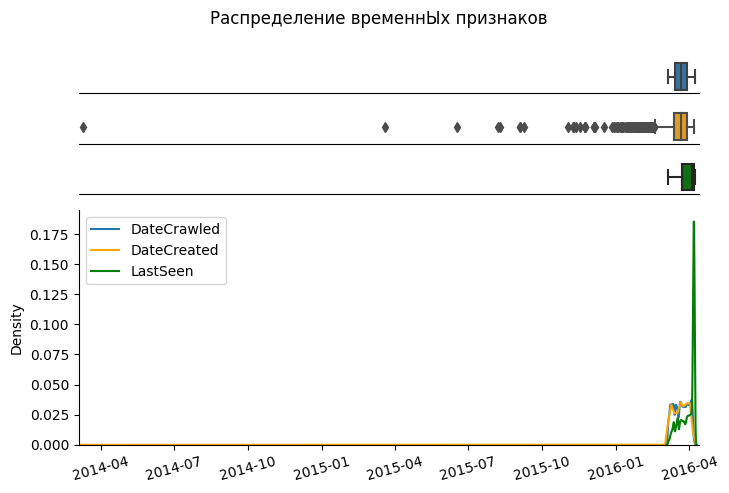

In [15]:
time_plot(range_min, range_max)

Значительный выброс влево в признаке DateCreated.\
Посмотрим распределение в уменьшенном диапазоне в пределах статистически значимой выборки (внутри "усов"):

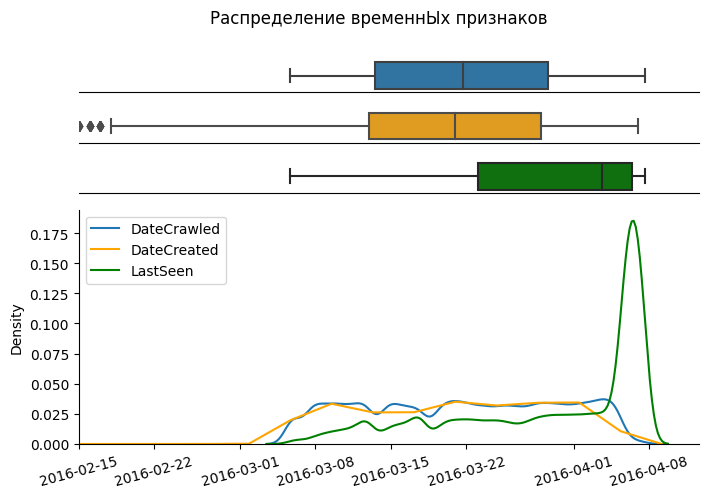

In [16]:
time_plot((pd.to_datetime('2016-02-15') - pd.to_datetime("1970-01-01"))//pd.Timedelta('1s'), range_max)

In [17]:
data.query("DateCreated<'2016-02-15'").shape[0] # кол-во объектов-выбросов по DateCreated

189

Доля выбросов в DateCreated 0.05% от всего датасета.\
Удалим данные выбросы:

In [18]:
data.drop(data[data['DateCreated']<'2016-02-15'].index, inplace=True)

Распределение логично. DateCreated происходит немного ранее DateCrawled.\
И значительно позднее, ближе к концу набдюдаемого периода идёт LastSeen.

### RegistrationYear

In [19]:
def plot_box_hist(s, range_min, range_max, name, kde=False):
    '''строит диаграмму размаха и гистограмму; на входе Series, диапазон, название'''
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8,4))
    sns.boxplot(x=s, ax=ax_box).set(xlabel=None, xlim=(range_min, range_max))
    sns.histplot(x=s, ax=ax_hist, element="step", kde=kde,
                 bins=round((s.max()-s.min())/(range_max-range_min)*100)) # 100 корзин на выводимом диапазоне
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist); sns.despine(ax=ax_box, left=True)
    f.suptitle(name); plt.show()

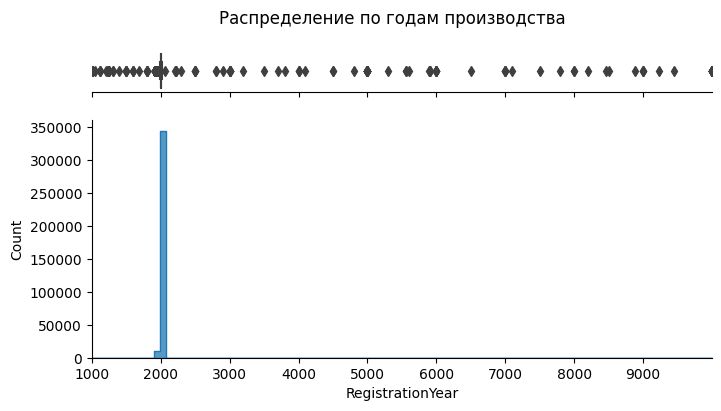

In [20]:
plot_box_hist(data['RegistrationYear'],data['RegistrationYear'].min(),data['RegistrationYear'].max(),
              'Распределение по годам производства')

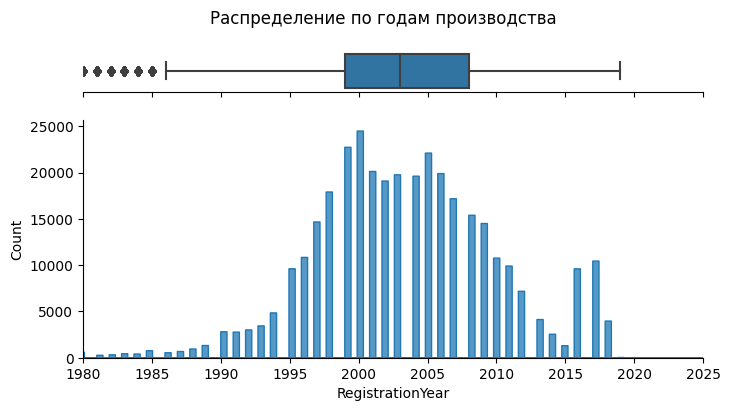

In [21]:
plot_box_hist(data['RegistrationYear'], 1980, 2025, 'Распределение по годам производства')

Наблюдаемый период в признаах LastSeen, DateCrawled, Date Created до апреля 2016г. Соответственно автомобили с годом производства позднее 2016г. не могли попасть в базу.\
Теоретически вероятно, что на рынке могут быть автомобили, сделанные на заре автомобильной отрасли и до 1980г., но их небольшое количество не окажет существенного влияния на модель.

In [22]:
data.query('RegistrationYear<1980 | RegistrationYear>2016').shape[0] # кол-во объектов-выбросов по RegistrationYear

17974

Доля выбросов в RegistrationYear 5% от всего датасета (17974 объекта; в т.ч. 14525 после 2016г.).\
Достаточно много, но не критично. Удалим выбросы:

In [23]:
data.drop(data.query('RegistrationYear<1980 | RegistrationYear>2016').index, inplace=True)

Помимо удалённых выбросов распределение носит нормальный характер. В 2016г. резкое увеличение числа. Причина пока неясна. Возможно тоже выброс. Выясним далее после изучения признака с месяцами регистрации. 

### RegistrationMonth

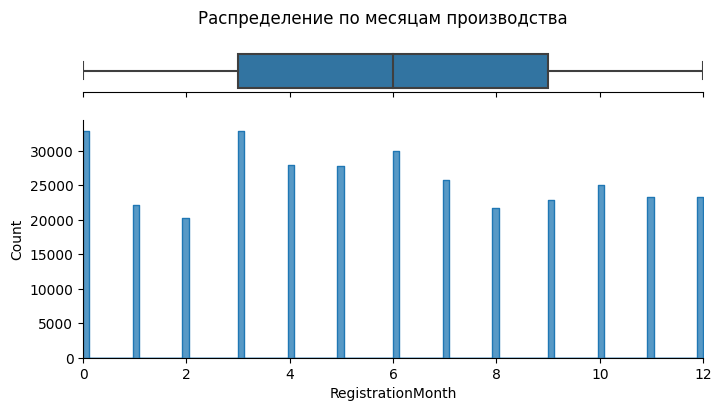

In [24]:
plot_box_hist(data['RegistrationMonth'],data['RegistrationMonth'].min(),data['RegistrationMonth'].max(),
              'Распределение по месяцам производства')

Присутствует нулевое значение, чего быть не может. Заменим на рандомное в диапазоне [1,12]:

In [25]:
random.seed(12345) #инициализация определённого генератора случайных чисел

In [26]:
data.loc[data['RegistrationMonth']==0,'RegistrationMonth'] =\
data.loc[data['RegistrationMonth']==0,'RegistrationMonth'].apply(lambda x: random.randint(1,12))

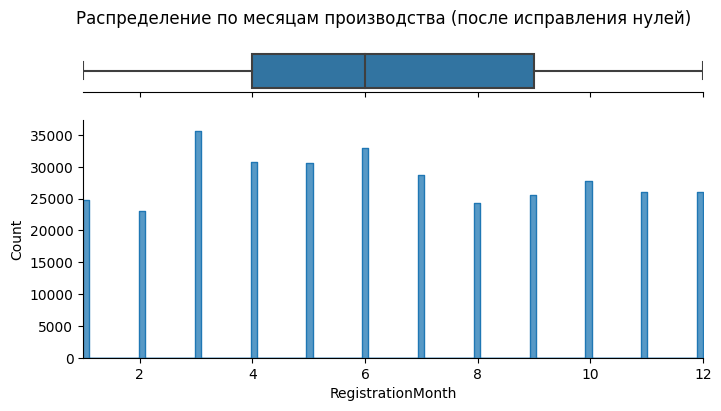

In [27]:
plot_box_hist(data['RegistrationMonth'],data['RegistrationMonth'].min(),data['RegistrationMonth'].max(),
              'Распределение по месяцам производства (после исправления нулей)')

Создадим признак из объединённых RegistrationYear и RegistrationMonth для сопоставления с другими временнЫми признаками.

In [28]:
data['RegistrationDate'] = pd.to_datetime(data['RegistrationYear'].astype(str)+'-'+data['RegistrationMonth'].astype(str))

Число объектов с датой регистрации (производства) большей даты создания анкеты:

In [29]:
data[data['RegistrationDate']>data['DateCreated']].shape[0]

7278

Доля выбросов в RegistrationDate 2% от всего оставшегося после предыдущих корректировок датасета (7278 объектов).\
Достаточно много, но не критично. Удалим выбросы:

In [30]:
data.drop(data[data['RegistrationDate']>data['DateCreated']].index, inplace=True)

In [31]:
round((354369-data.shape[0])/354369, 2)           # доля удалённых объектов от исходного датасета

0.07

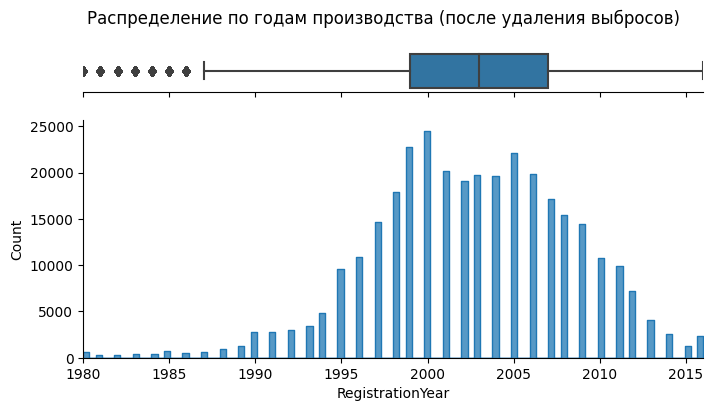

In [32]:
plot_box_hist(data['RegistrationYear'],data['RegistrationYear'].min(),data['RegistrationYear'].max(),
              'Распределение по годам производства (после удаления выбросов)')

Пик в 2016г. значительно уменьшился и вписывается в общее нормальное распределение с учётом небольших колебаний.

### Kilometer

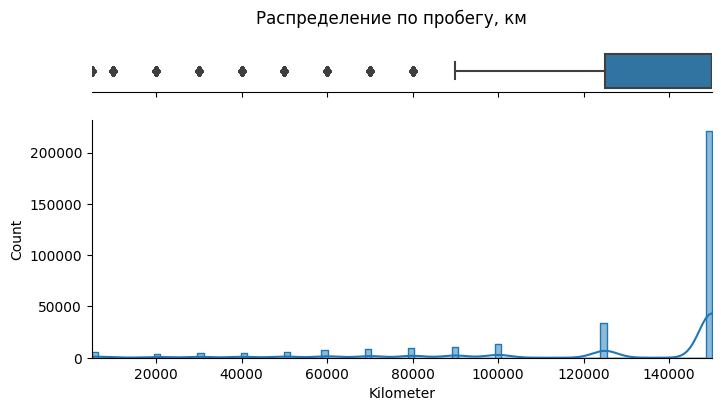

In [33]:
plot_box_hist(data['Kilometer'],data['Kilometer'].min(),data['Kilometer'].max(), 'Распределение по пробегу, км', kde=True)

In [34]:
np.sort(data['Kilometer'].unique()) # уникальные значения пробега

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000], dtype=int64)

Пробег категоризирован. Аномалии не выявлены. Распределение правдоподобно для рынка вторичных автомобилей.

### Price

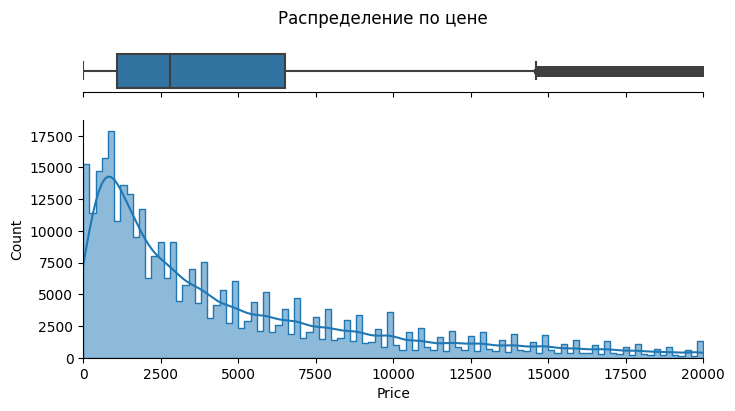

In [35]:
plot_box_hist(data['Price'],data['Price'].min(),data['Price'].max(), 'Распределение по цене', kde=True)

In [36]:
data['Price'].describe()

count    328924.000000
mean       4499.298339
std        4542.681775
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

Изучим значения менее €100.

In [37]:
data.query('Price==0').shape[0] # кол-во нулевух значений

9259

In [38]:
data.query('Price<100').describe()[['RegistrationYear','Power','Kilometer']] # описание объектов с ценой до €100

RegistrationYear         Power      Kilometer
count      11522.000000  11522.000000   11522.000000
mean        1999.247006     76.344298  122072.556848
std            6.326634    181.463126   50654.776425
min         1980.000000      0.000000    5000.000000
25%         1996.000000      0.000000  125000.000000
50%         1999.000000     68.000000  150000.000000
75%         2002.000000    116.000000  150000.000000
max         2016.000000  10317.000000  150000.000000

С мизерной ценой (или без) чаще всего объекты 1999 года выпуска и с километражом 150 т. То есть старые авто в плохом состоянии.\
Нули можно заместить медианой по объектам в этом диапазоне года и пробега.\
Проверим количество относительно новых объектов (до 6 лет) и с низким пробегом (до 10 т. км):

In [39]:
data.query('Price==0 & Kilometer<10000 & RegistrationYear > 2010').shape[0]

70

Эти машины могут быть в аварийном состоянии и тогда их цена невысокая, сопоставима с ценой старого автомобиля.\
Либо продавцы по каким-то причинам не хотят обозначать стоимость своего хорошего нового авто. Если мы пропишем здесь медианную цену старого автомобиля, будет не соответствие реальной стоимости, неправильный прогноз. Но с учётом небольшого количества данных объектов возможный неверный прогноз не окажет серьёзного влияния на модель.

In [40]:
# медианная цена автомобиля с пробегом 150 т.км
price_median_150000 = data.loc[data['Kilometer']==150000,'Price'].median()
price_median_150000

2050.0

In [41]:
# замена нулей (и символической цены до 100) в цене на медианное значение машин с пробегом 150 т.км
data.loc[data['Price']<100,'Price'] = price_median_150000

In [42]:
data.sort_values(by='Price', ascending=False).head(10) # топ-10 объектов с максимальной ценой

DateCrawled    Price VehicleType  RegistrationYear Gearbox  \
247893 2016-03-22 12:55:40  20000.0         bus              2009     NaN   
113554 2016-03-29 13:53:58  20000.0       wagon              2014  manual   
216236 2016-03-29 20:44:33  20000.0       small              2011    auto   
342303 2016-03-29 20:54:22  20000.0       sedan              2013  manual   
1515   2016-03-09 10:18:36  20000.0       sedan              2010    auto   
63806  2016-03-20 11:53:10  20000.0       sedan              2007    auto   
94360  2016-03-16 14:53:41  20000.0       sedan              2011    auto   
63866  2016-03-12 19:48:58  20000.0       sedan              2015  manual   
18312  2016-03-05 15:45:49  20000.0       wagon              2011  manual   
333309 2016-03-12 09:55:15  20000.0       small              2015  manual   

        Power        Model  Kilometer  RegistrationMonth  FuelType  \
247893      0  transporter     150000                  9       NaN   
113554    124        auris      30000                  6  gasoline   
216236    185           a1      60000                 12    petrol   
342303    194     insignia      60000                 10  gasoline   
1515      239           a6     150000                  5  gasoline   
63806     207        other      70000                  8  gasoline   
94360     265     c_klasse      50000                 11  gasoline   
63866     208      2_reihe      20000                  9    petrol   
18312     250     insignia      50000                  9    petrol   
333309    125         golf      20000                  3    petrol   

                Brand Repaired DateCreated  NumberOfPictures  PostalCode  \
247893     volkswagen       no  2016-03-22                 0       78315   
113554         toyota       no  2016-03-29                 0       80807   
216236           audi       no  2016-03-29                 0       46045   
342303           opel       no  2016-03-29                 0       76698   
1515             audi       no  2016-03-07                 0       56567   
63806          jaguar       no  2016-03-20                 0       26789   
94360   mercedes_benz       no  2016-03-16                 0       10115   
63866         peugeot       no  2016-03-12                 0       56766   
18312            opel       no  2016-03-05                 0       91466   
333309     volkswagen       no  2016-03-12                 0       58135   

                  LastSeen  DateCrawled_unix  DateCreated_unix  LastSeen_unix  \
247893 2016-03-31 09:44:21        1458651340        1458604800     1459417461   
113554 2016-04-05 23:47:09        1459259638        1459209600     1459900029   
216236 2016-04-06 06:45:40        1459284273        1459209600     1459925140   
342303 2016-04-06 07:17:21        1459284862        1459209600     1459927041   
1515   2016-03-30 19:17:04        1457518716        1457308800     1459365424   
63806  2016-04-06 10:16:27        1458474790        1458432000     1459937787   
94360  2016-03-16 15:43:30        1458140021        1458086400     1458143010   
63866  2016-04-05 12:21:03        1457812138        1457740800     1459858863   
18312  2016-04-03 09:47:15        1457192749        1457136000     1459676835   
333309 2016-04-06 01:46:21        1457776515        1457740800     1459907181   

       RegistrationDate  
247893       2009-09-01  
113554       2014-06-01  
216236       2011-12-01  
342303       2013-10-01  
1515         2010-05-01  
63806        2007-08-01  
94360        2011-11-01  
63866        2015-09-01  
18312        2011-09-01  
333309       2015-03-01

Из топ-10 объектов с максимальной ценой аномалии без более детальной отработки (анализом прайс-листов производителей) сложно выявить.\
Полагаясь на поверхностный анализ и гистограмму выбросов либо нет, либо их минимальное количество значимо невлияющих на модель.

### Power

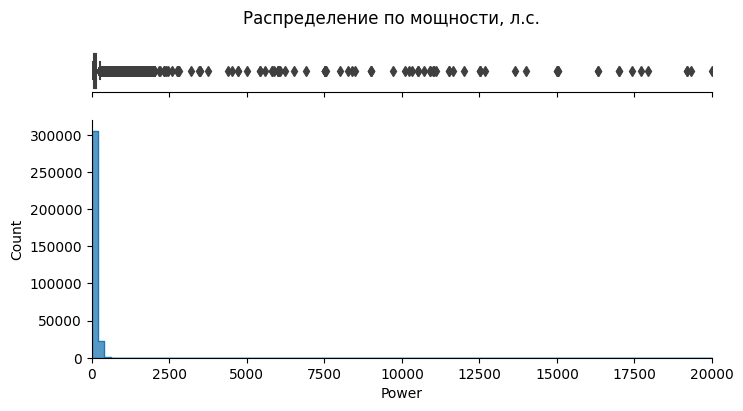

In [43]:
plot_box_hist(data['Power'],data['Power'].min(),data['Power'].max(), 'Распределение по мощности, л.с.')

Мощность современных спортивных автомобилей до 1500 л.с.

In [44]:
data.query('Power>1500').shape[0] # количество объектов с мощностью выше 1500

175

In [45]:
data.sort_values(by='Power',ascending=False).head() # топ-5 автомобилей с максимальной мощностью

DateCrawled   Price VehicleType  RegistrationYear Gearbox  \
219584 2016-03-09 15:43:53  4300.0       coupe              1999    auto   
299180 2016-03-09 08:53:11  1500.0       wagon              1997  manual   
114106 2016-04-03 07:36:21  9999.0       sedan              2006  manual   
132485 2016-03-25 14:55:49  2100.0       wagon              2001  manual   
63986  2016-03-28 11:49:56  3250.0       sedan              2001    auto   

        Power  Model  Kilometer  RegistrationMonth  FuelType          Brand  \
219584  20000    clk     150000                  1    petrol  mercedes_benz   
299180  19312    5er     150000                  1       NaN            bmw   
114106  19211    1er     125000                  3  gasoline            bmw   
132485  19208    5er     150000                  5       NaN            bmw   
63986   17932  omega     150000                  6    petrol           opel   

       Repaired DateCreated  NumberOfPictures  PostalCode            LastSeen  \
219584       no  2016-03-09                 0       19406 2016-03-30 08:47:08   
299180       no  2016-03-09                 0       21129 2016-04-07 11:44:34   
114106      NaN  2016-04-03                 0       45964 2016-04-07 10:16:10   
132485      yes  2016-03-25                 0       59556 2016-03-30 05:16:18   
63986       NaN  2016-03-28                 0       86641 2016-04-06 14:17:21   

        DateCrawled_unix  DateCreated_unix  LastSeen_unix RegistrationDate  
219584        1457538233        1457481600     1459327628       1999-01-01  
299180        1457513591        1457481600     1460029474       1997-01-01  
114106        1459668981        1459641600     1460024170       2006-03-01  
132485        1458917749        1458864000     1459314978       2001-05-01  
63986         1459165796        1459123200     1459952241       2001-06-01

Гипотезы возможной причины дынных завышенных значений (на примере топовой позиции 20000):
- значения указаны в Вт (1 л.с. = 735 Вт); 20000/735=27; слишком мало; гипотеза не подтверждается;
- значения указаны в $см^3$, как объём двигателя (1000 $см^3$ = 1л, что ориентировочно соответсвует 100 л.с.); 20000 $см^3$ = 20л ~ 2000 л.с.; слишком много; гипотеза не подтверждается;
- значения указаны в $дюйм^3$, как объём двигателя (1000 $дюйм^3$ = 16л, что ориентировочно соответсвует 1600 л.с.); 20000 $дюйм^3$ = 328л; обсурдно много; гипотеза не подтверждается;
- значения завышены в 100 раз; 20000/100=200 л.с. - вполне вероятно.

Значения мощности у объектов со значениями выше 1500 сократим в 100 раз. Вероятно попадутся позиции, у которых может быть иная логика завышенного значения (например, опечатка). Или может быть ещё у какого-то кол-ва объектов "менее 1500" тоже значение завышено в 100 раз, а мы их не исправим. Тем не менее позитивный эффект от данного исправления всё равно будет. Число объектов с иной логикой завышения или не попавших в диапазон ">1500" не значительно.

In [46]:
data.loc[data['Power']>1500,'Power'] /= 100

При поверхностном осмотре датасета спортивных автомобилей с мощностью 500-1500 л.с. не вижу.\
Скорее всего значение завышено в 10 раз.

In [47]:
data.query('500<Power<=1500').shape[0] # число объектов с мощностью от 500 до 1500

221

In [48]:
# сокращение в 10 раз значения мощности в диапазоне 500-1500
data.loc[(data['Power']>500) & (data['Power']<=1500), 'Power'] /=10

Рассмотрим минимальные значения мощности.

In [49]:
data.query('Power == 0').shape[0] # количество объектов с нулевой мощностью

33215

In [50]:
# медианное описание объектов с нулевой мощностью
data.query('Power == 0').describe()[['RegistrationYear','Kilometer','Price']].loc['50%'] 

RegistrationYear      2000.0
Kilometer           150000.0
Price                 1680.0
Name: 50%, dtype: float64

In [51]:
# заполним нулевые значения медианами стратифицированными по наименованию модели
for m in data.query('Power == 0')['Model'].unique():
    data.loc[(data['Power']==0) & (data['Model']==m),'Power'] =\
    data.loc[(data['Power']!=0) & (data['Model']==m),'Power'].median()

In [52]:
data.query('Power == 0').shape[0] # количество объектов с нулевой мощностью (после заполнения медианами)

4855

Большую часть заполнили. В оставшихся нулевых не нашлось соответствующей модели. Заполним их медианами стратифицированными по брендам:

In [53]:
for b in data.query('Power == 0')['Brand'].unique():
    data.loc[(data['Power']==0) & (data['Brand']==b),'Power'] =\
    data.loc[(data['Power']!=0) & (data['Brand']==b),'Power'].median()

In [54]:
data.query('Power == 0').shape[0] # количество объектов с нулевой мощностью (после повторного заполнения медианами)

0

In [55]:
data.query('0<Power<40').shape[0] # количество объектов с мощностью в интервале (0,50)

1303

Мало вероятны такие низкие значения мощностей.\
Мощности до 40 заполним значением 40. Теоретически, со значением около 40 л.с. могут быть малогабаритные автомобили.

In [56]:
data.loc[(data['Power']>0)&(data['Power']<40),'Power'] = 40

In [57]:
data[data['Power'].isna()] # объект с пропуском

DateCrawled   Price VehicleType  RegistrationYear Gearbox  \
132006 2016-03-09 16:38:02  2050.0         NaN              1980     NaN   

        Power    Model  Kilometer  RegistrationMonth  FuelType       Brand  \
132006    NaN  serie_3     100000                  1  gasoline  land_rover   

       Repaired DateCreated  NumberOfPictures  PostalCode            LastSeen  \
132006      NaN  2016-03-09                 0       44787 2016-04-07 03:46:31   

        DateCrawled_unix  DateCreated_unix  LastSeen_unix RegistrationDate  
132006        1457541482        1457481600     1460000791       1980-01-01

In [58]:
# заполним пропуск медианой расчитанной по другим схожим автомобилям
data.loc[data['Power'].isna(), 'Power'] = data.loc[(data['Brand']=="land_rover") &
                                                   (data['FuelType'] == "gasoline") & 
                                                   (data['RegistrationYear']>1975) & 
                                                   (data['RegistrationYear']<1985), 'Power'].median()

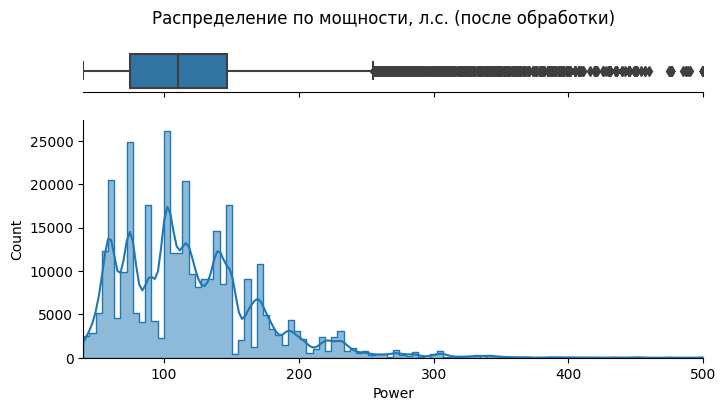

In [59]:
plot_box_hist(data['Power'],data['Power'].min(),data['Power'].max(), 
              'Распределение по мощности, л.с. (после обработки)', kde=True)

### NumberOfPictures

In [60]:
data['NumberOfPictures'].value_counts()  # уникальные значения и их количества

0    328924
Name: NumberOfPictures, dtype: int64

Вероятно, информация ошибочная. Не может быть объявлений без фотографий.\
Тем не менее для ML данный признак бесполезный и удаляется полностью:

In [61]:
data.drop('NumberOfPictures', axis=1, inplace=True)

### PostalCode

In [62]:
data['PostalCode'].value_counts().head() # топ уникальных значений

10115    814
65428    565
66333    314
44145    293
52525    289
Name: PostalCode, dtype: int64

In [63]:
data['PostalCode'].value_counts().shape[0] # количество уникальных значений

8130

In [64]:
# кол-во почтовых кодов с числом объявлений от 40 и выше
data['PostalCode'].value_counts()[data['PostalCode'].value_counts()>=40].shape[0]

2893

In [65]:
# сумма объявлений в регионах (почтовых кодах), у которых число объявлений от 40 и выше
data['PostalCode'].value_counts()[data['PostalCode'].value_counts()>=40].sum()

248902

Таким образом, примерно треть регионов (почтовых кодов) делают три четверти объявлений.\
Эту треть сохраним в PostalCode_pop, остальные коды переименуем в 0.\
Благодаря этому на 2/3 сократим число уникальных значений кодов, не потеряв информацию о самых популярных регионах. Снизим нагрузку на вычислительные мощности.

In [66]:
PostalCode_pop = data['PostalCode'].value_counts()[data['PostalCode'].value_counts()>=40].index

In [67]:
data.loc[~data['PostalCode'].isin(PostalCode_pop),'PostalCode'] = 0

### Brand

In [68]:
# все категориальные строчные признаки приводим к нижнему регистру и убираем пробелы с краёв (при наличии)
for c in (['VehicleType', 'Gearbox', 'Model','FuelType', 'Brand', 'Repaired']):
    data[c] = data[c].str.lower().str.strip()

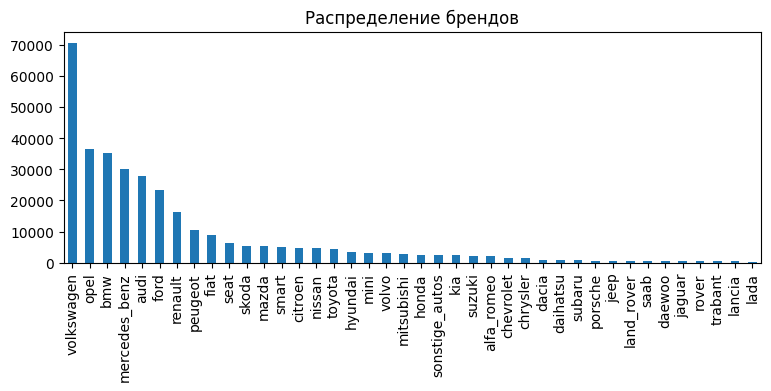

In [69]:
data['Brand'].value_counts().plot(kind='bar',figsize=(9,3), title='Распределение брендов')
plt.show()

Неявных дубликатов нет. Пропусков нет.

### Model

In [70]:
np.sort(data['Model'][~data['Model'].isna()].unique()) # уникальные значения; смотрим неявные дубликаты

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [71]:
# замена неявного дубликата
data.loc[data['Model']=='rangerover', 'Model'] = 'range_rover'

In [72]:
def gaps(series):
    '''выводит число и долю пропусков по переданному названию признака'''
    print('количество пропусков, шт:', data[series].isna().sum())
    print('их доля:                 ', round(data[series].isna().sum()/data.shape[0], 2))

In [73]:
gaps('Model')

количество пропусков, шт: 15763
их доля:                  0.05


In [74]:
# пропуски заполняем значением 'unknown'
data.loc[data['Model'].isna(), 'Model'] = 'unknown'

### VehicleType

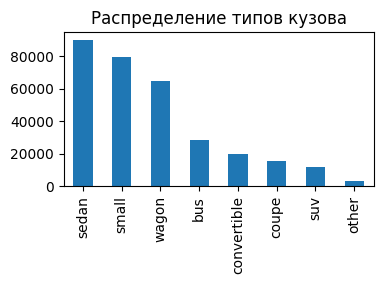

In [75]:
data['VehicleType'].value_counts().plot(kind='bar',figsize=(4,2),title='Распределение типов кузова')
plt.show()

In [76]:
gaps('VehicleType')

количество пропусков, шт: 15289
их доля:                  0.05


In [77]:
# пропуски заполняем значением 'unknown'
data.loc[data['VehicleType'].isna(), 'VehicleType'] = 'unknown'

### Gearbox

In [78]:
gaps('Gearbox')

количество пропусков, шт: 16184
их доля:                  0.05


In [79]:
# пропуски заполняем значением 'unknown'
data.loc[data['Gearbox'].isna(), 'Gearbox'] = 'unknown'

In [80]:
def bar_box(series,box_x,bar_title,box_title):
    '''выводит столбчатую диаграмму по "series" и диаграмму разброса "series" по "box_x"'''
    f, (ax_1, ax_2) = plt.subplots(1,2,figsize=(12,data[series].nunique()*0.4),gridspec_kw={"wspace": 0.3})
    sns.countplot(data=data, y=series,ax=ax_1)
    sns.boxplot(data=data, x=box_x, y=series,ax=ax_2)
    ax_1.set_title(bar_title); ax_2.set_title(box_title)
    sns.despine(ax=ax_1, left=True); ax_1.set(xlabel=None,ylabel=None)
    sns.despine(ax=ax_2,left=True);  ax_2.set(xlabel=None,ylabel=None)

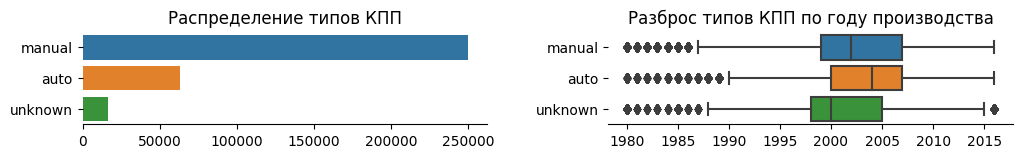

In [81]:
bar_box('Gearbox','RegistrationYear','Распределение типов КПП','Разброс типов КПП по году производства')

Если бы диаграммы разброса 'manual' или 'auto' однозначно совпадали с 'unknown' можно было бы сделать вывод, какая коробка бередач у машин с пропущенными значениями. Но все три разброса примерно находятся в одном диапазоне. Оставляем 'unknown'.

### FuelType

In [82]:
gaps('FuelType')

количество пропусков, шт: 23664
их доля:                  0.07


In [83]:
# пропуски заполняем значением 'unknown'
data.loc[data['FuelType'].isna(), 'FuelType'] = 'unknown'

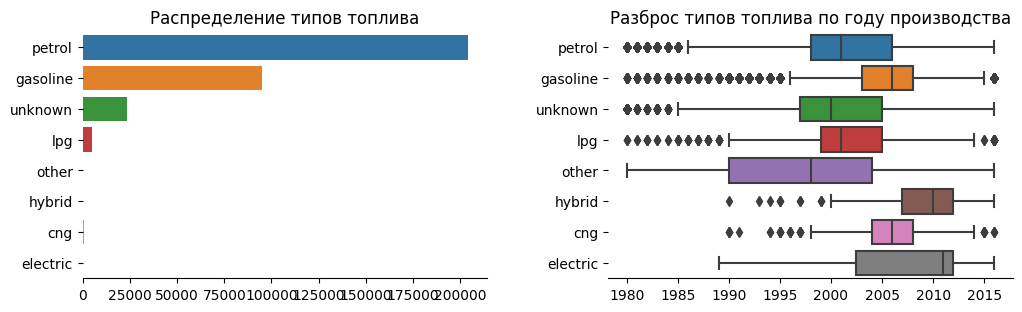

In [84]:
bar_box('FuelType','RegistrationYear','Распределение типов топлива','Разброс типов топлива по году производства')

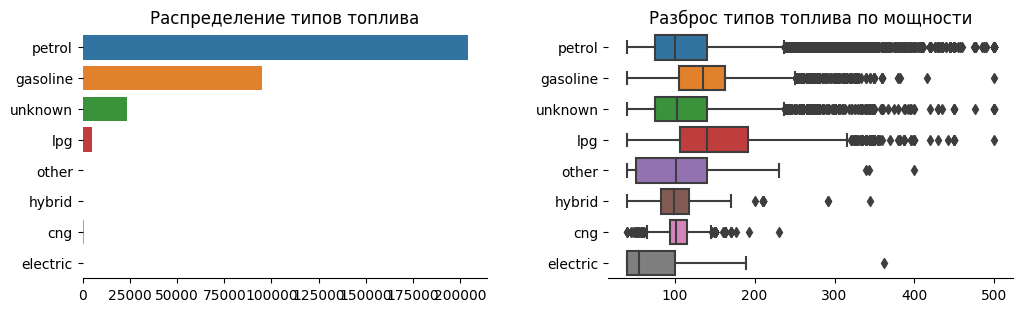

In [85]:
bar_box('FuelType','Power','Распределение типов топлива','Разброс типов топлива по мощности')

Видим почти идентичный разброс 'unknown' c 'petrol', в первую очередь по мощности, но также и по году производства.\
Можно сделать вывод, что большинство пропущенных значений в признаке 'FuelType' - 'petrol'.

In [86]:
# заполняем пропуски ('unknown') значением 'petrol'
data['FuelType'].where(data['FuelType'] != 'unknown', 'petrol',inplace=True)

### Repaired

In [87]:
gaps('Repaired')

количество пропусков, шт: 60294
их доля:                  0.18


In [88]:
# пропуски заполняем значением 'unknown'
data.loc[data['Repaired'].isna(), 'Repaired'] = 'unknown'

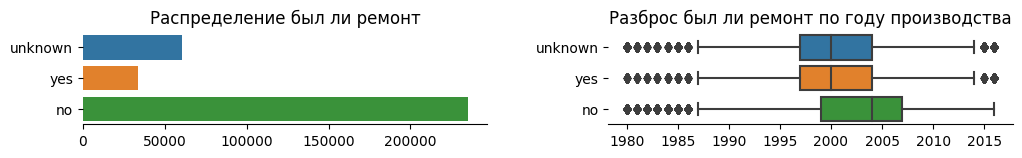

In [89]:
bar_box('Repaired','RegistrationYear','Распределение был ли ремонт','Разброс был ли ремонт по году производства')

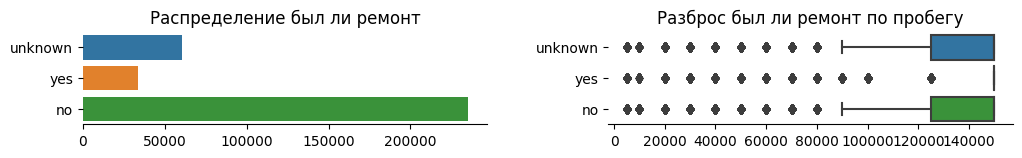

In [90]:
bar_box('Repaired','Kilometer','Распределение был ли ремонт','Разброс был ли ремонт по пробегу')

Видим выше 2 разброса по году производства и по пробегу. Можно сделать разный вывод:\
в разбросе по году распределение 'unknown' идентично ремонтированным машинам, но изначительно пересекается с неремонтированными;\
в разбросе по пробегу распределение 'unknown' идентично неремонтированным машинам.\
С одной стороны, судя по тому, что разброс по пробегу показывает бОльшую идентичность 'unknown' с неремонтированными, можно предположить, что пропущенные значения это машины не подвергнутые ременту.\
Но с другой стороны объявления от 2016г., и пропущенные значения у объектов в основном изготовленных в 2000г.  За 10-16 лет крайне мало вероятно, что автомобиль не ремонтировался.\
Заключаем, что в пропущенных значениях в большинстве случаев должно быть "yes":

In [91]:
data['Repaired'] = data['Repaired'].replace('unknown', 'yes')

### Матрица корреляции

Кодирование в этой части проекта необходимо для визуализации взаимосвязи признаков - определение коэффициентов Пирсона, построение матриц рассеяния.

In [92]:
# кодируем категориальные текстовые данные
encoder_corr = OrdinalEncoder()
data_ordinal=pd.DataFrame(encoder_corr.fit_transform (data[[c for c in data if data[c].dtype == object]]), 
                                                   columns=[c for c in data if data[c].dtype == object]).join(
                                                      data[[c for c in data if data[c].dtype != object]])

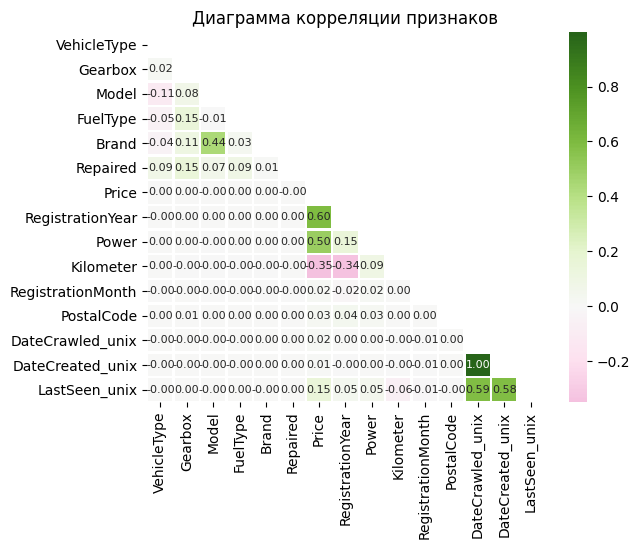

In [93]:
matrix = np.triu(data_ordinal.corr())
sns.heatmap(data_ordinal.corr(),annot=True, cmap='PiYG', linewidth=1, fmt='.2f', center= 0, 
            annot_kws={"size":8}, mask=matrix).set_title('Диаграмма корреляции признаков'); plt.show()

Наблюдаем корреляцию:
- слабую отрицательную между 'Kilometer' и 'Price','RegistrationYear';
- среднюю положительную между 'Price' и 'Power','RegistrationYear';
- слабую положительную между 'Brand' и 'Model'.

### Диаграммы рассеяния

In [94]:
col_a = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand','Repaired', 'Price']
col_b = ['RegistrationYear', 'Power', 'Kilometer','RegistrationMonth', 'PostalCode','DateCreated_unix', 'LastSeen_unix']

Ниже наблюдаем различные степени зависимости между признаками - наличие пустот, сгустков, линий. В том числе 'Price' с остальными.

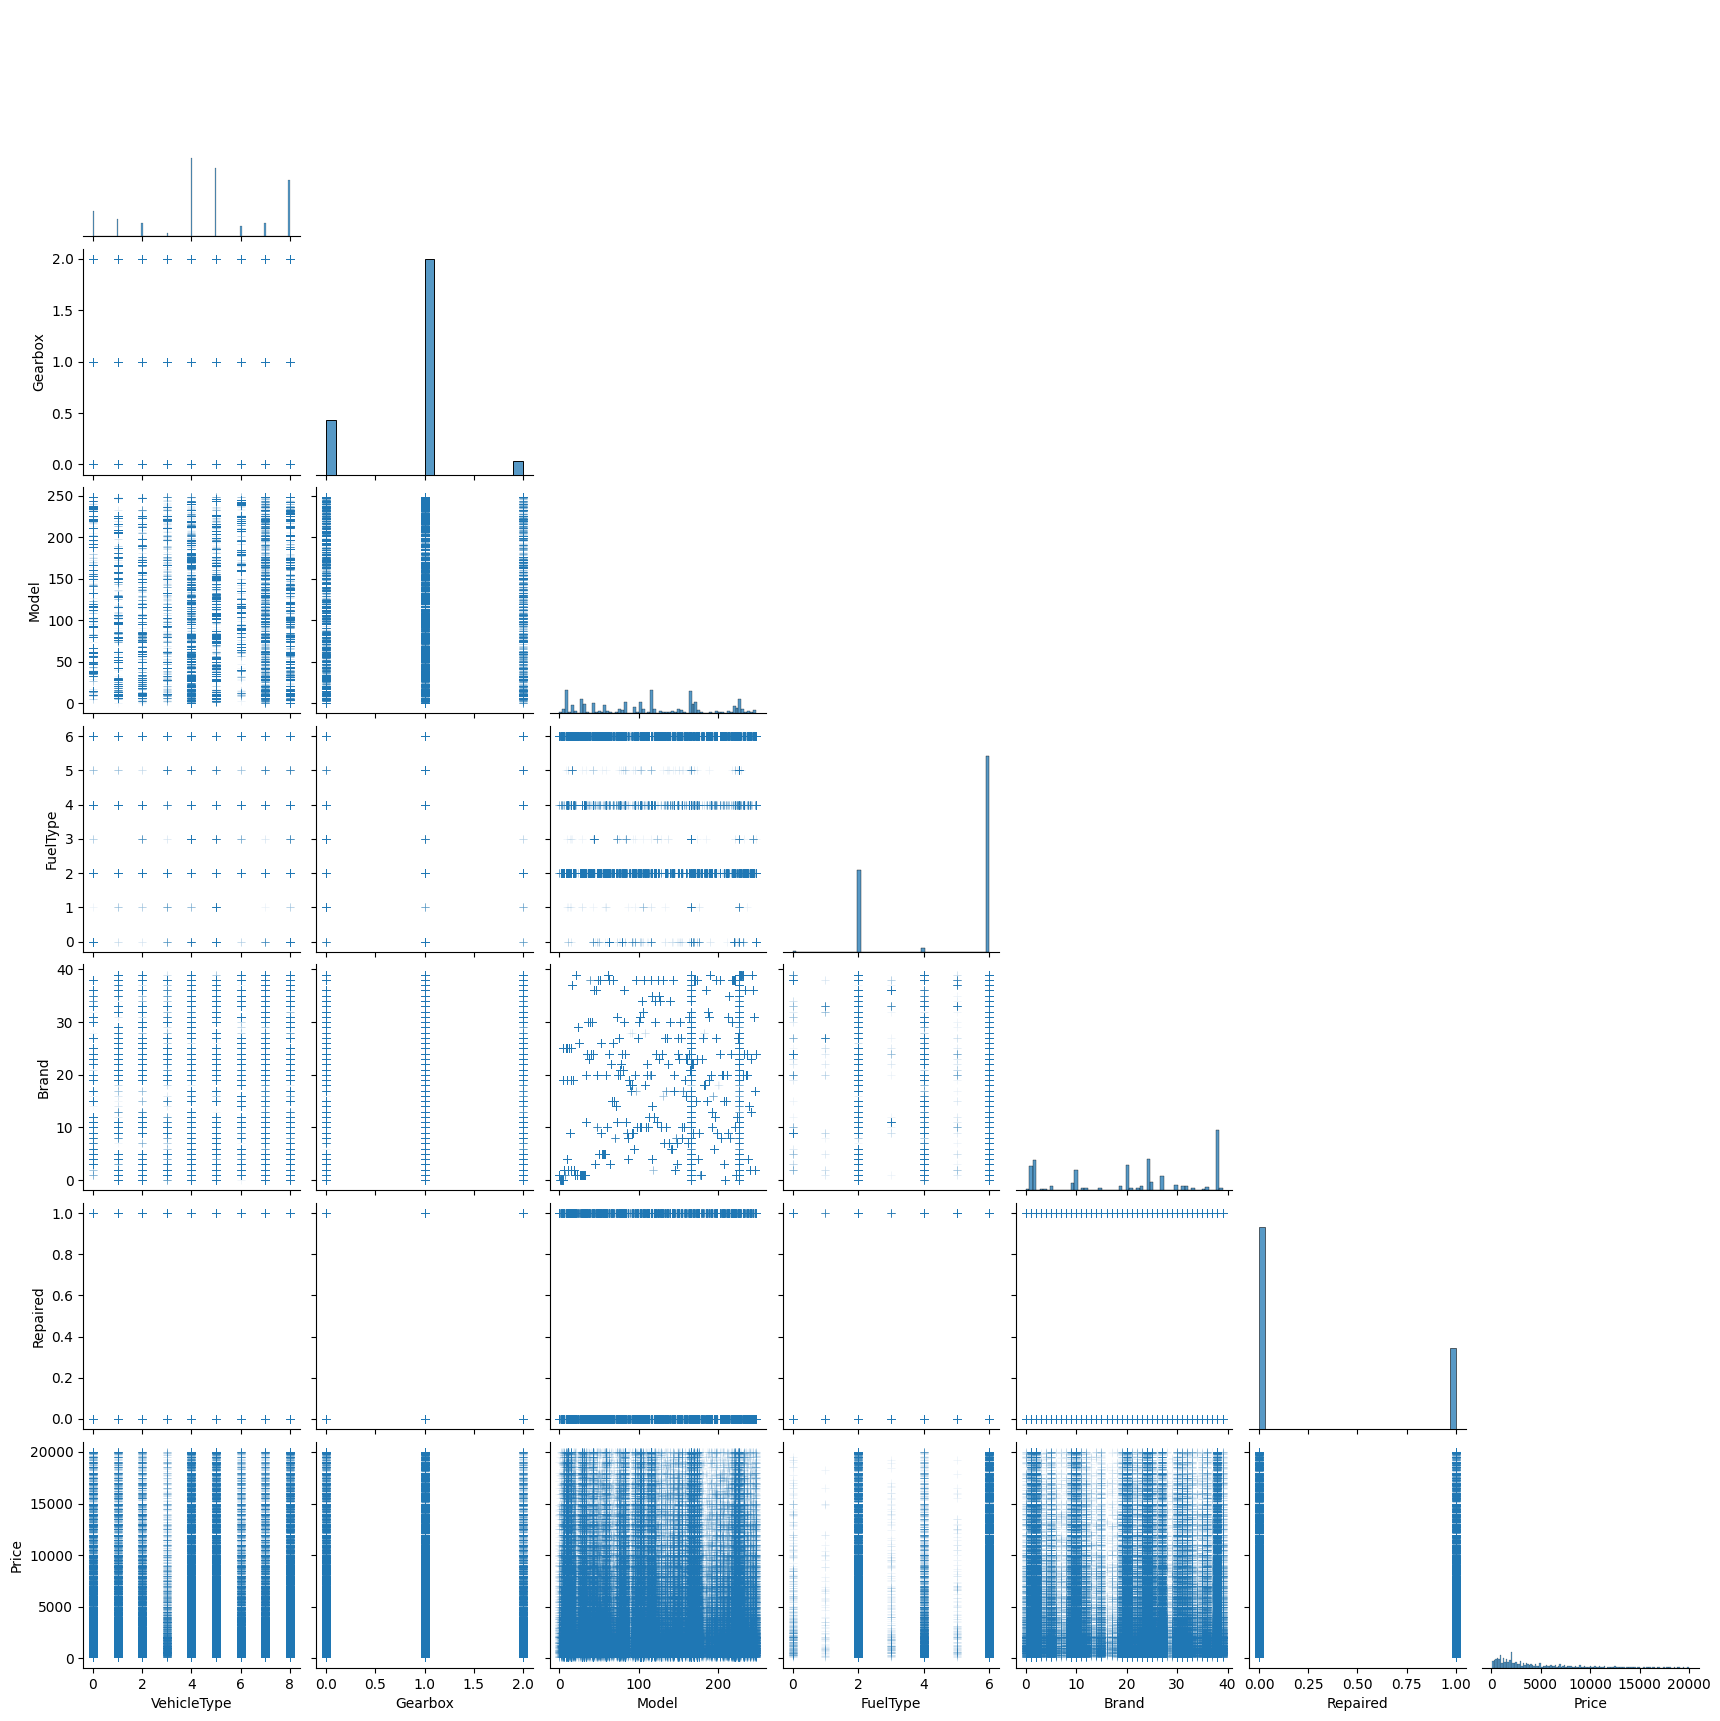

In [95]:
sns.pairplot(data_ordinal[col_a],plot_kws=dict(alpha=0.1, marker="+"),corner=True); plt.show()

Какие-то бренды дороже, какие-то дешевле. Также с моделями и типами кузовов.

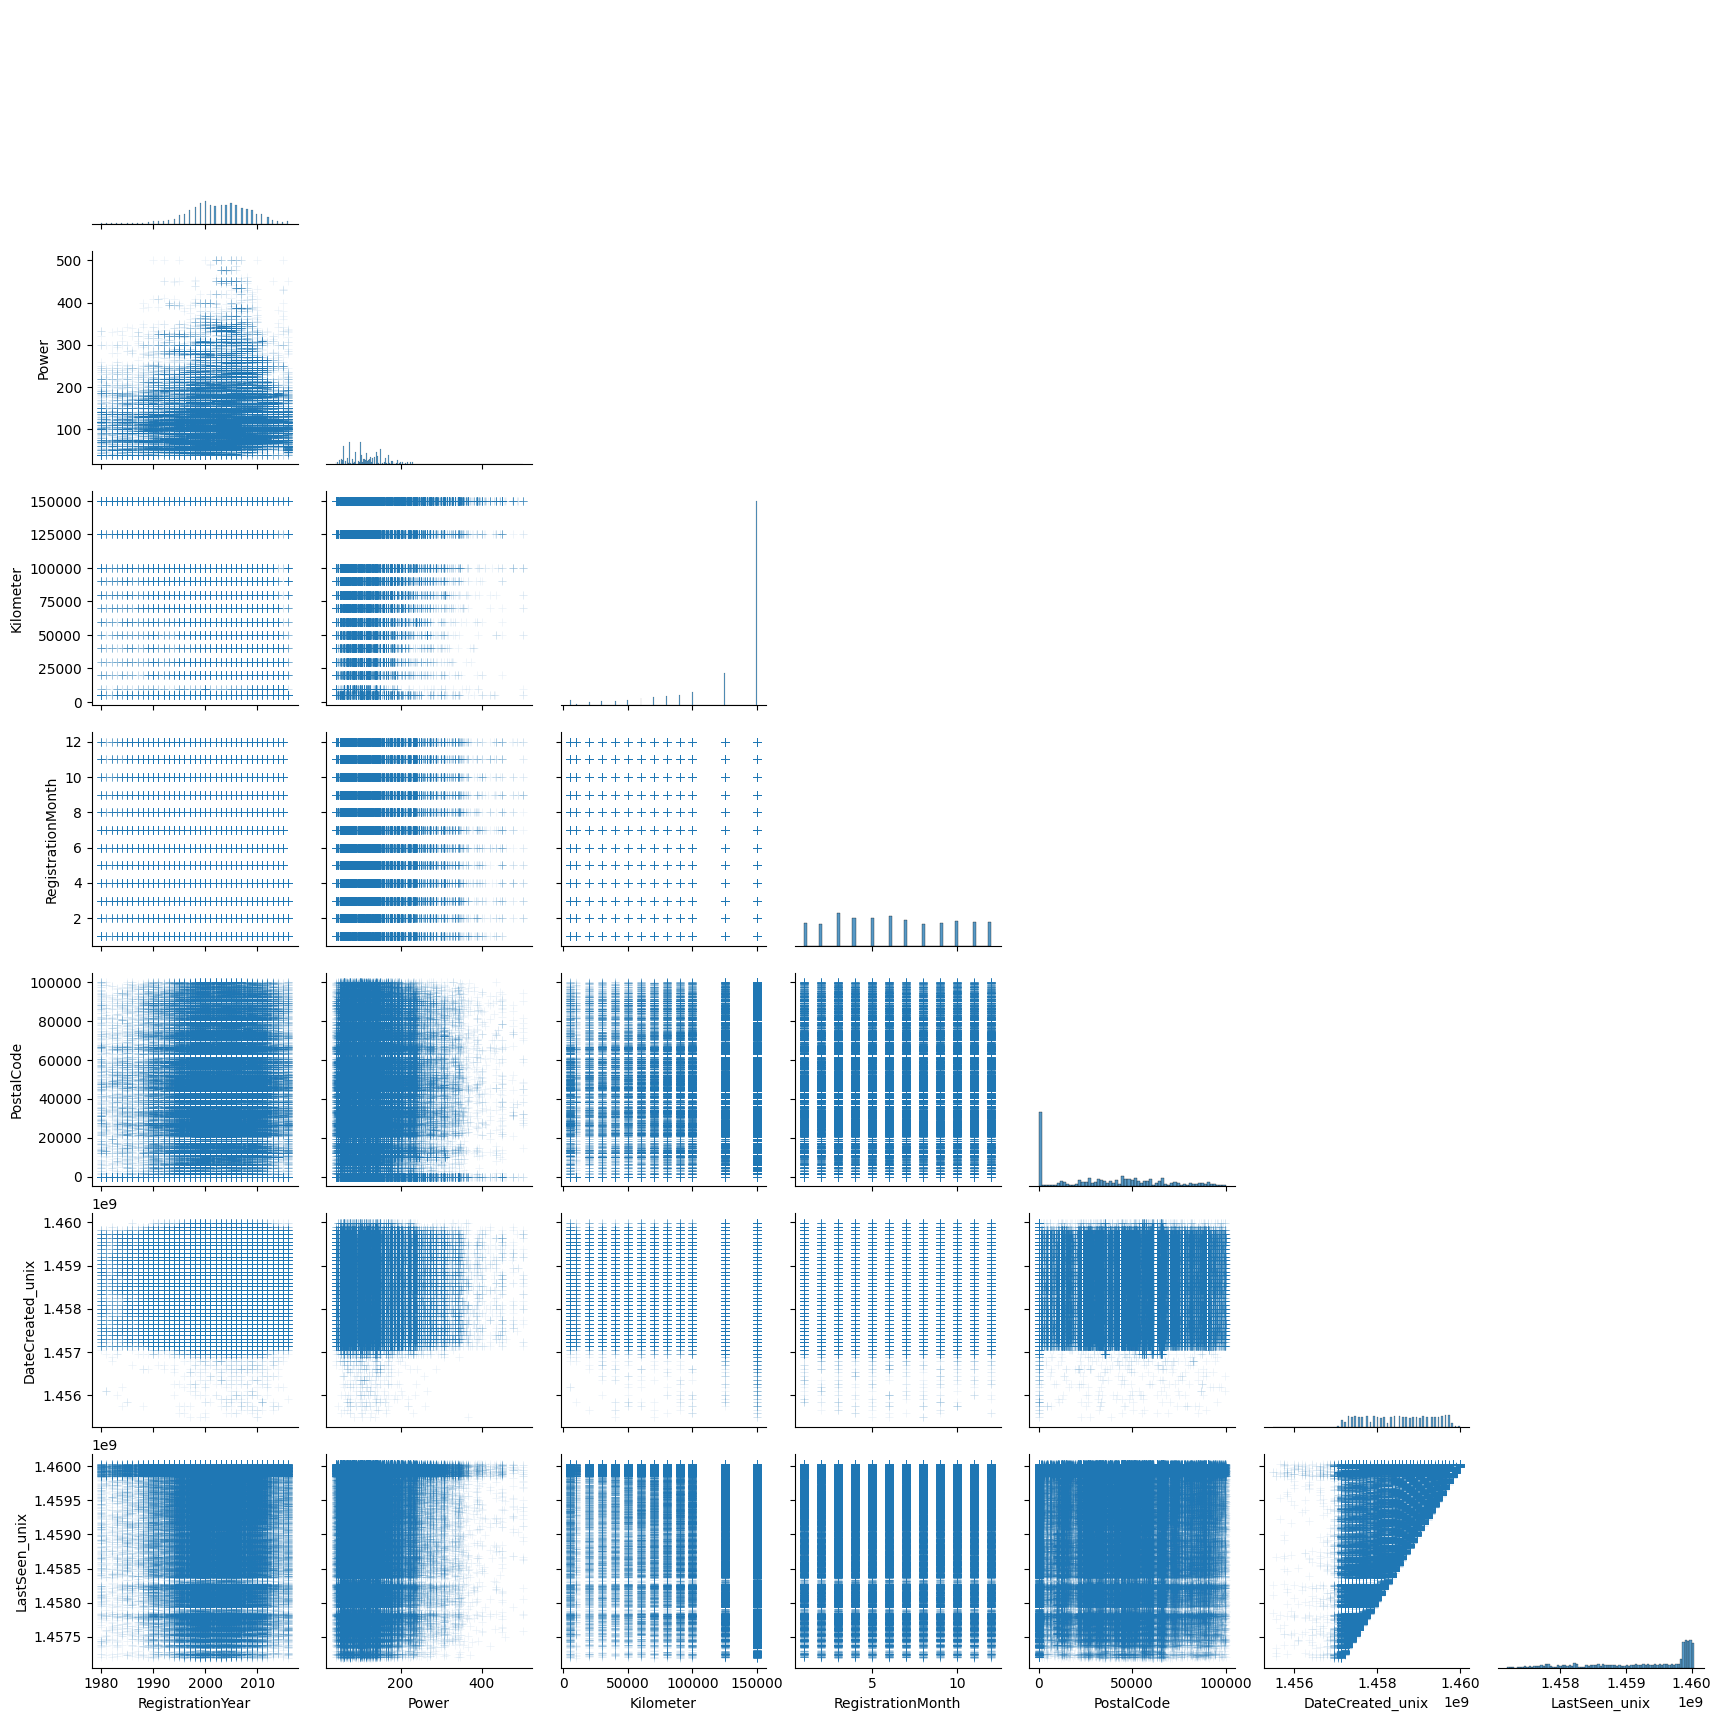

In [96]:
sns.pairplot(data_ordinal[col_b],plot_kws=dict(alpha=0.1, marker="+"),corner=True); plt.show()

Чем больше год регистрации (младше автомобиль) тем выше мощность.\
При большей мощности выше пробег.

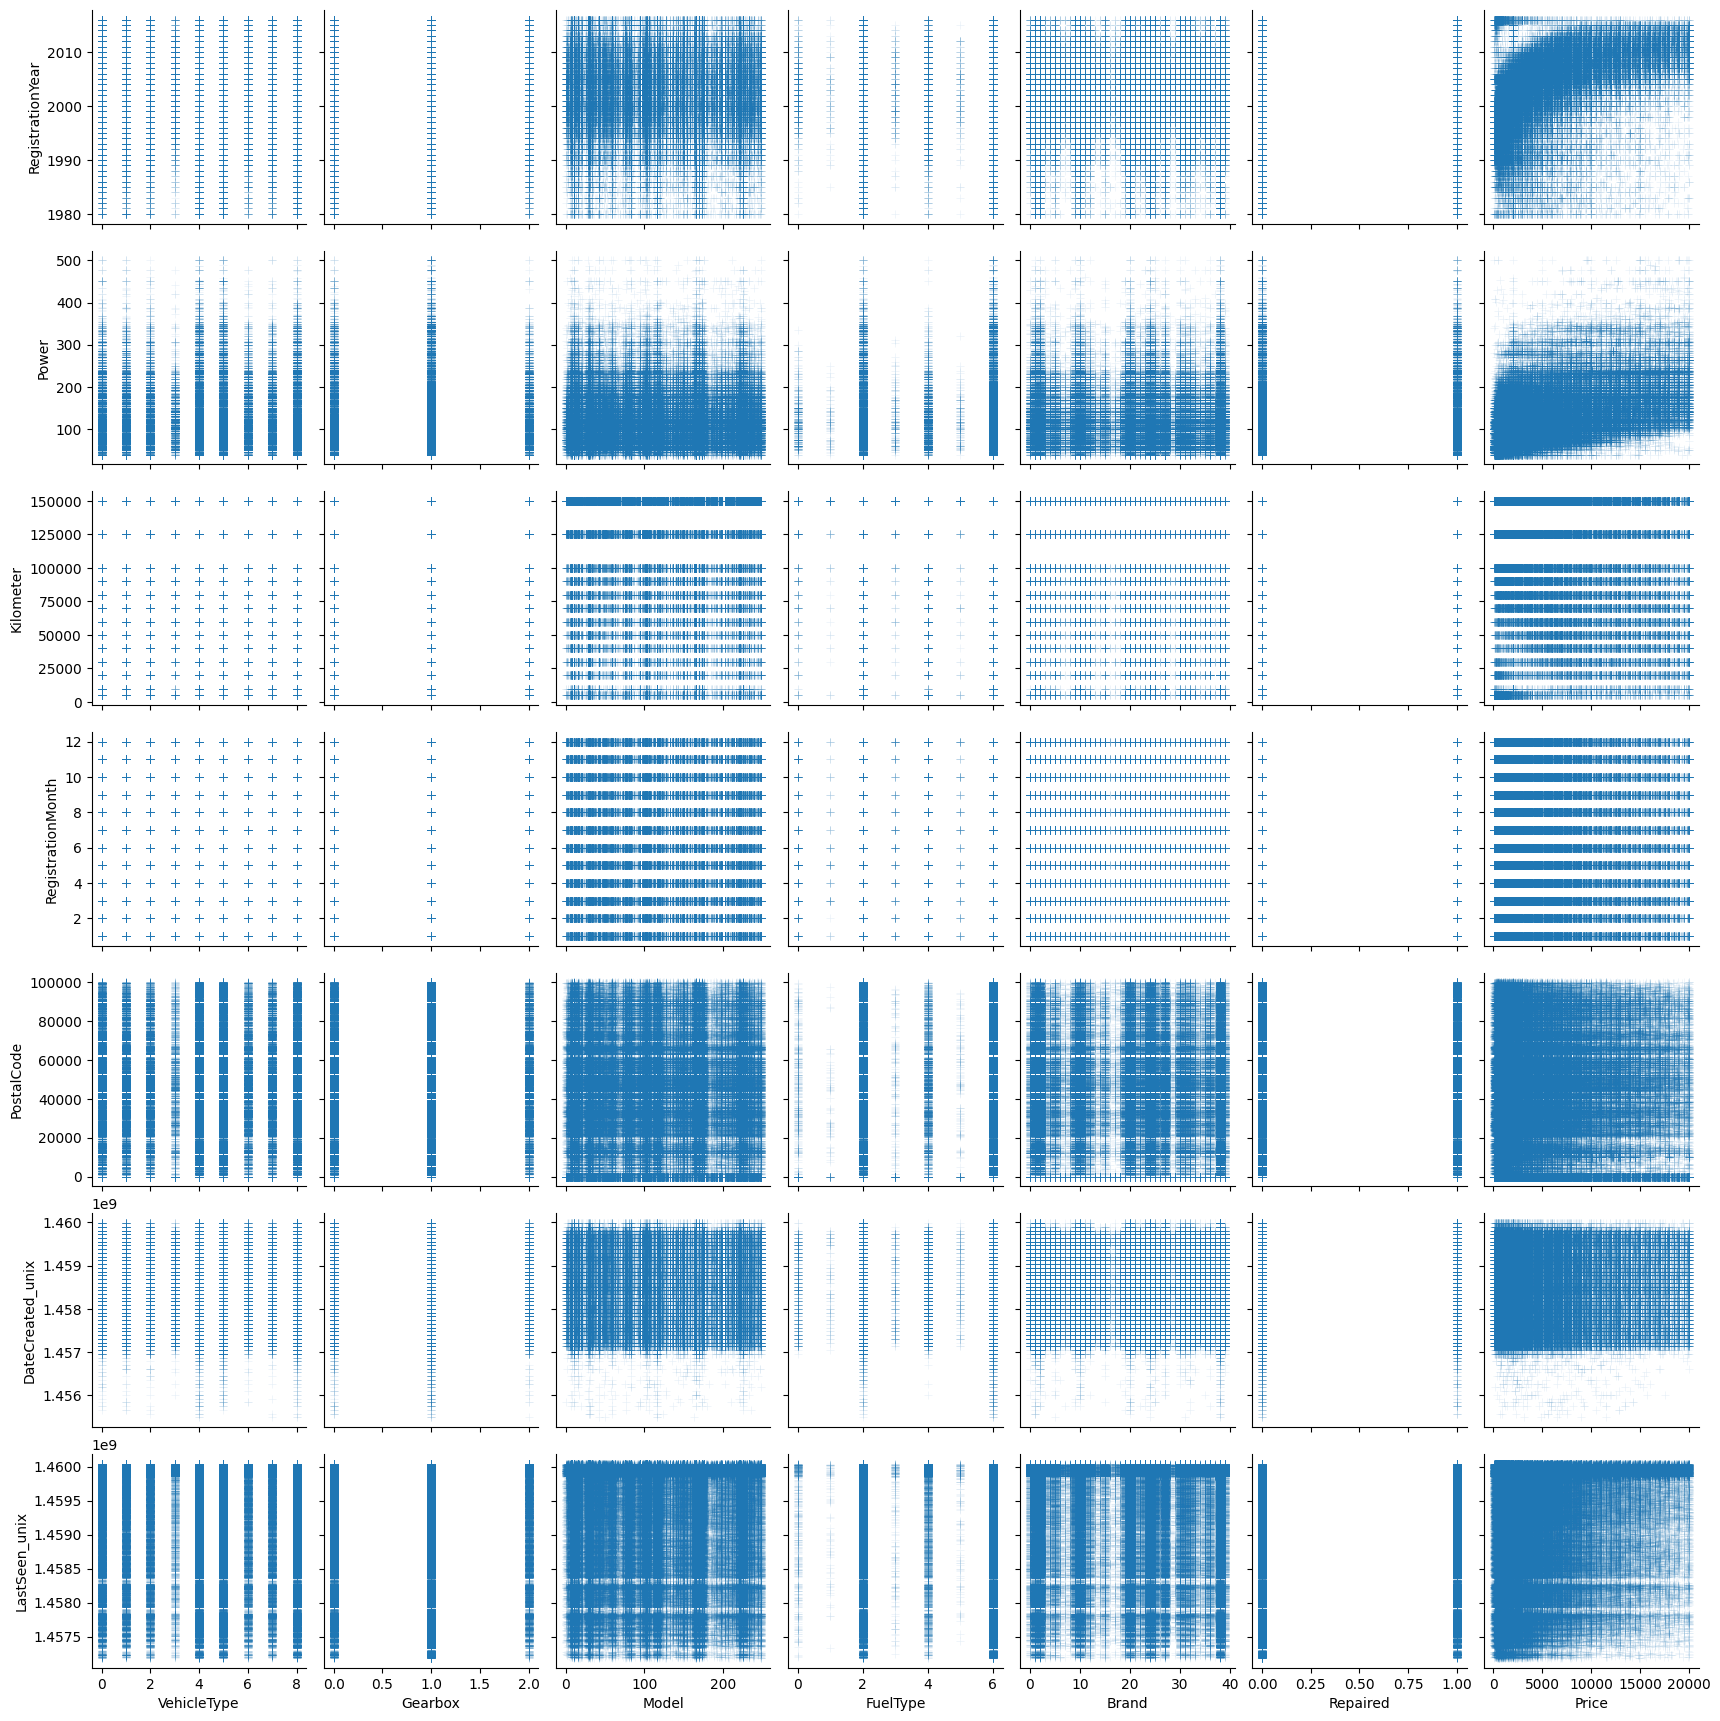

In [97]:
sns.pairplot(data_ordinal,x_vars=col_a,y_vars=col_b,plot_kws=dict(alpha=0.1, marker="+")); plt.show()

Нелинейная "выпуклая" зависимость между возрастом автомобиля и ценой. Чем младше автомобиль (выше год регистрации) тем выше цена.\
Видим явно выраженную зависимость меду мощностью и ценой.

Заключение по разделу анализа и предобработки данных включено в [итоговый вывод](#вывод).

## Machine learning

### Split, Encoding, Scaling

In [98]:
# определяем признаки (наиболее значимые) и целевой признак
features = data[['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 
                 'Brand', 'Repaired', 'PostalCode', 'LastSeen_unix']]
target   = data['Price']

In [99]:
# разбиваем df на обучающую (f_tn,t_tn) и тестовую выборки (f_tt,t_tt); (0.75, 0.25)
f_tn, f_tt, t_tn, t_tt = train_test_split(features, target, test_size=0.25, random_state=12345)

In [100]:
# размеры полученных выборок
print(f_tn.shape, t_tn.shape) # features_train, target_train
print(f_tt.shape, t_tt.shape) # features_test,  target_test

(246693, 11) (246693,)
(82231, 11) (82231,)


In [101]:
# определяем категориальные и числовые признаки
col_cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'PostalCode']
col_num = ['RegistrationYear', 'Power', 'Kilometer', 'LastSeen_unix']

**Ordinal Encoding**

In [102]:
# кодируем (по OE) категориальные текстовые данные
encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
encoder.fit(f_tn[col_cat])

def to_ordinal(df):
    '''преобразует категориальные признаки в числовые; на входе df'''
    return pd.DataFrame(encoder.transform(df[col_cat]), df.index, col_cat).join(df[col_num])

f_tn_oe = to_ordinal(f_tn)
f_tt_oe = to_ordinal(f_tt)

In [103]:
# масштабирование признаков
scaler = StandardScaler()
scaler.fit(f_tn_oe)
f_tn_oe_sc = scaler.transform(f_tn_oe)
f_tt_oe_sc = scaler.transform(f_tt_oe)

**One Hot Encoding**

In [104]:
# кодируем (по OHE) категориальные текстовые данные (для Linear regression)
encoder_ohe = OneHotEncoder(drop='first',handle_unknown='ignore',dtype='int8')
encoder_ohe.fit(f_tn[col_cat])

def to_ohe(df):
    '''преобразует категориальные признаки по OHE; на входе df'''
    return pd.DataFrame(encoder_ohe.transform(df[col_cat]).toarray(), 
                        df.index, 
                        encoder_ohe.get_feature_names_out())\
                        .join(df[col_num])
f_tn_ohe = to_ohe(f_tn)
f_tt_ohe = to_ohe(f_tt)

In [105]:
# масштабирование числовых признаков (OHE)
scaler_ohe = StandardScaler()
scaler_ohe.fit(f_tn_ohe[col_num])
f_tn_ohe_sc = np.concatenate((scaler_ohe.transform(f_tn_ohe[col_num]),
                              f_tn_ohe[encoder_ohe.get_feature_names_out()].values),
                             axis=1)
f_tt_ohe_sc = np.concatenate((scaler_ohe.transform(f_tt_ohe[col_num]),
                              f_tt_ohe[encoder_ohe.get_feature_names_out()].values),
                             axis=1)

### Linear regression

In [106]:
%%time
model = LinearRegression()
round((cross_val_score(model, f_tn_ohe_sc, t_tn, cv=3, scoring='neg_mean_squared_error')*(-1)).mean()**0.5) # RMSE

CPU times: total: 12min 58s
Wall time: 4min 3s


2457

Попробуем модель с регуляризацией.

In [107]:
%%time
# расчёт RMSE с разными коэффициентами регуляризации
for a in np.arange(0,1.1,0.2):
    model = Ridge(alpha=a)
    print(f"alpha = {a},\
            RMSE = {(cross_val_score(model, f_tn_ohe_sc, t_tn, cv=3, scoring='neg_mean_squared_error')*(-1)).mean()**0.5:.0f}")

alpha = 0.0,            RMSE = 1655301791591640
alpha = 0.2,            RMSE = 2457
alpha = 0.4,            RMSE = 2456
alpha = 0.6000000000000001,            RMSE = 2456
alpha = 0.8,            RMSE = 2456
alpha = 1.0,            RMSE = 2456
CPU times: total: 26min 53s
Wall time: 10min 40s


### DecisionTreeRegressor

In [108]:
%%time
model = DecisionTreeRegressor(random_state=12345)
parametrs = {'max_depth': range (3,21),
             'criterion': ('squared_error', 'friedman_mse', 'poisson'),
             'min_samples_split': range(2,11),
             'min_samples_leaf':  range(1,11)}
grid_dtr = GridSearchCV(estimator = model, param_grid = parametrs, scoring = 'neg_mean_squared_error',cv=3)
grid_dtr.fit(f_tn_oe_sc,t_tn)

CPU times: total: 2h 26min 2s
Wall time: 2h 26min 6s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'criterion': ('squared_error', 'friedman_mse',
                                       'poisson'),
                         'max_depth': range(3, 21),
                         'min_samples_leaf': range(1, 11),
                         'min_samples_split': range(2, 11)},
             scoring='neg_mean_squared_error')

In [109]:
# наименьшее RMSE
round((grid_dtr.best_score_*(-1))**0.5)

1901

In [110]:
# гиперпараметры при наименьшем RMSE
pd.DataFrame(grid_dtr.cv_results_).sort_values(by='rank_test_score')['params'].reset_index(drop=True)[0]

{'criterion': 'poisson',
 'max_depth': 16,
 'min_samples_leaf': 10,
 'min_samples_split': 7}

### RandomForestRegressor

In [111]:
%%time
model_rfr = RandomForestRegressor(random_state=12345)

parametrs = {'max_depth': range (12,21),
             'criterion': ('squared_error', 'friedman_mse', 'poisson'),
             'min_samples_split': range(2,11),
             'min_samples_leaf':  range(1,15),
             'n_estimators': range(20,221,20)}

grid_rfr = RandomizedSearchCV(estimator = model_rfr, param_distributions = parametrs, random_state = 123, cv = 3, n_iter=25,
                              scoring = 'neg_mean_squared_error')
grid_rfr.fit(f_tn_oe_sc,t_tn)

CPU times: total: 1h 36min 8s
Wall time: 1h 36min 11s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=12345),
                   n_iter=25,
                   param_distributions={'criterion': ('squared_error',
                                                      'friedman_mse',
                                                      'poisson'),
                                        'max_depth': range(12, 21),
                                        'min_samples_leaf': range(1, 15),
                                        'min_samples_split': range(2, 11),
                                        'n_estimators': range(20, 221, 20)},
                   random_state=123, scoring='neg_mean_squared_error')

In [112]:
# наименьшее RMSE
round((grid_rfr.best_score_*(-1))**0.5)

1650

In [113]:
# гиперпараметры при наименьшем RMSE
pd.DataFrame(grid_rfr.cv_results_).sort_values(by='rank_test_score')['params'].reset_index(drop=True)[0]

{'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_depth': 20,
 'criterion': 'poisson'}

Уменьшаем пространство вариаций:

In [114]:
%%time
model_rfr = RandomForestRegressor(random_state=12345, criterion= 'poisson')

parametrs = {'max_depth': range (16,25),
             'min_samples_split': range(3,6),
             'min_samples_leaf':  range(3,6),
             'n_estimators': range(90,201,10)}

grid_rfr = RandomizedSearchCV(estimator = model_rfr, param_distributions = parametrs, random_state = 123, cv = 3, n_iter=10,
                              scoring = 'neg_mean_squared_error')
grid_rfr.fit(f_tn_oe_sc,t_tn)

CPU times: total: 54min 46s
Wall time: 54min 47s


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(criterion='poisson',
                                                   random_state=12345),
                   param_distributions={'max_depth': range(16, 25),
                                        'min_samples_leaf': range(3, 6),
                                        'min_samples_split': range(3, 6),
                                        'n_estimators': range(90, 201, 10)},
                   random_state=123, scoring='neg_mean_squared_error')

In [115]:
# наименьшее RMSE
round((grid_rfr.best_score_*(-1))**0.5)

1645

In [116]:
# гиперпараметры при наименьшем RMSE
pd.DataFrame(grid_rfr.cv_results_).sort_values(by='rank_test_score')['params'].reset_index(drop=True)[0]

{'n_estimators': 200,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_depth': 24}

In [117]:
# сводная таблица по данным перебора
pd.DataFrame(grid_rfr.cv_results_).sort_values(by='rank_test_score')[['rank_test_score','param_n_estimators',
                                                                      'param_min_samples_split','param_min_samples_leaf',
                                                                      'param_max_depth','mean_test_score']].\
                                                                       set_index('rank_test_score')

param_n_estimators param_min_samples_split  \
rank_test_score                                              
1                              200                       3   
2                              140                       3   
2                              140                       5   
4                              130                       5   
5                               90                       5   
6                              190                       4   
7                              160                       3   
8                              180                       4   
9                               90                       3   
10                             120                       4   

                param_min_samples_leaf param_max_depth  mean_test_score  
rank_test_score                                                          
1                                    3              24    -2.707611e+06  
2                                    3              23    -2.712368e+06  
2                                    3              23    -2.712368e+06  
4                                    3              24    -2.713932e+06  
5                                    3              22    -2.720636e+06  
6                                    4              23    -2.736061e+06  
7                                    4              23    -2.738495e+06  
8                                    4              18    -2.757822e+06  
9                                    4              18    -2.767130e+06  
10                                   5              18    -2.789103e+06

### Feature importance based on mean decrease in impurity

In [118]:
%%time
model = RandomForestRegressor(random_state=12345,n_estimators=200,max_depth=24,min_samples_split=3,
                              min_samples_leaf=3,criterion='poisson')
model.fit(f_tn_oe_sc,t_tn)

CPU times: total: 3min 45s
Wall time: 3min 45s


RandomForestRegressor(criterion='poisson', max_depth=24, min_samples_leaf=3,
                      min_samples_split=3, n_estimators=200,
                      random_state=12345)

In [119]:
%%time
importances = model.feature_importances_
feature_names = f_tn_oe.columns
forest_importances = pd.Series(importances, index=feature_names)

CPU times: total: 141 ms
Wall time: 179 ms


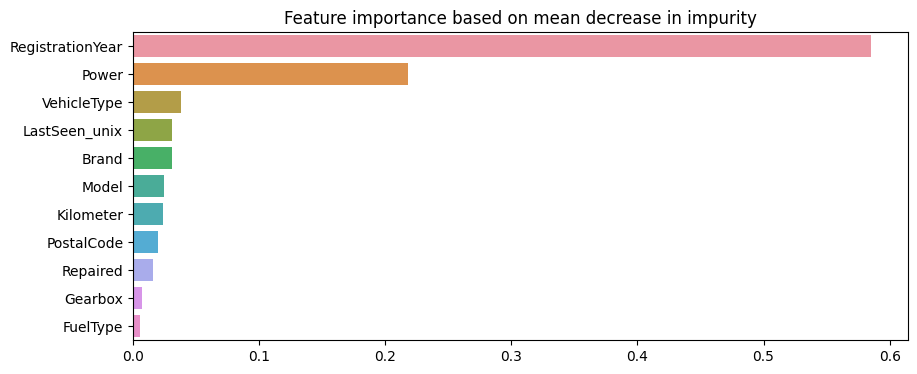

In [120]:
plt.figure(figsize=(10,4))
sns.barplot(x=forest_importances.sort_values(ascending=False),
            y=forest_importances.sort_values(ascending=False).index).set(
    title='Feature importance based on mean decrease in impurity')
plt.show()

### Feature importance based on feature permutation

In [130]:
%%time
result = permutation_importance(model, f_tn_oe_sc, t_tn, n_repeats=10, random_state=42)

CPU times: total: 18min 46s
Wall time: 18min 48s


In [131]:
forest_importances_2 = pd.Series(result.importances_mean, index=feature_names)

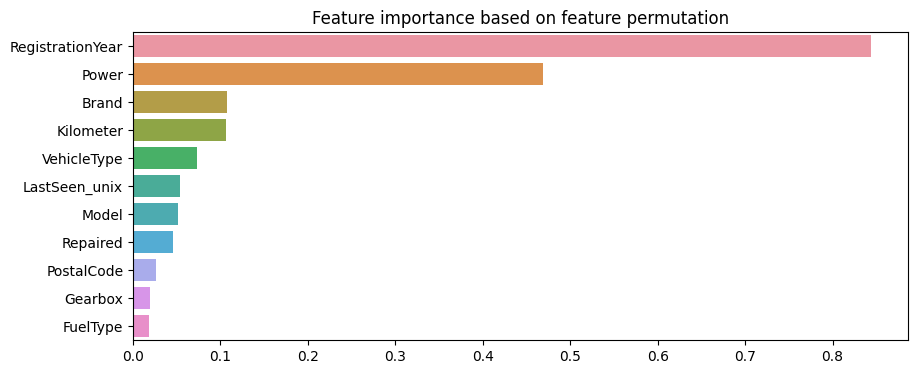

In [132]:
plt.figure(figsize=(10,4))
ax = sns.barplot(x=forest_importances_2.sort_values(ascending=False),
                 y=forest_importances_2.sort_values(ascending=False).index).set(
    title='Feature importance based on feature permutation')
plt.show()

В документации Sklearn [говорится](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#:~:text=Permutation%20feature%20importance%20overcomes%20limitations%20of%20the%20impurity%2Dbased%20feature%20importance%3A%20they%20do%20not%20have%20a%20bias%20toward%20high%2Dcardinality%20features%20and%20can%20be%20computed%20on%20a%20left%2Dout%20test%20set.), что 'Feature importance based on feature permutation' более правдоподобный, чем 'Feature importance based on mean decrease in impurity'. Судя по результатам действительно второй вариант выглядит более правдоподобно.

#### Качество модели с меньшим числом признаков

**4 наиболее влиятельных признака**

In [133]:
f_tn_oe_4 = f_tn_oe[['Brand', 'RegistrationYear', 'Power', 'Kilometer']]

In [134]:
# масштабирование признаков
scaler_4 = StandardScaler()
scaler_4.fit(f_tn_oe_4)
f_tn_oe_sc_4 = scaler_4.transform(f_tn_oe_4)

In [135]:
%%time
model = RandomForestRegressor(random_state=12345,n_estimators=200,max_depth=24,min_samples_split=3,
                              min_samples_leaf=3,criterion='poisson')
round((cross_val_score(model, f_tn_oe_sc_4, t_tn, cv=3, scoring='neg_mean_squared_error')*(-1)).mean()**0.5)

CPU times: total: 1min 42s
Wall time: 1min 42s


1870

**8 наиболее влиятельных признаков**

In [136]:
f_tn_oe_8 = f_tn_oe[['Brand', 'RegistrationYear', 'Power', 'Kilometer', 'VehicleType','LastSeen_unix','Model','Repaired']]

In [137]:
# масштабирование признаков
scaler_8 = StandardScaler()
scaler_8.fit(f_tn_oe_8)
f_tn_oe_sc_8 = scaler_8.transform(f_tn_oe_8)

In [138]:
%%time
model = RandomForestRegressor(random_state=12345,n_estimators=200,max_depth=24,min_samples_split=3,
                              min_samples_leaf=3,criterion='poisson')
round((cross_val_score(model, f_tn_oe_sc_8, t_tn, cv=3, scoring='neg_mean_squared_error')*(-1)).mean()**0.5)

CPU times: total: 5min 30s
Wall time: 5min 30s


1676

Сокращение числа признаков не улучшило метрику качества. Хотя при 8-ми признаках метрика близка к значению метрики при 11-ти - 1645.

### CatBoost

In [139]:
def catboost_cv(depth, iterations, learning_rate):
    '''с помощью кросс-валидации возвращает RMSE_min и номер итерации при RMSE_min; 
       на входе глубина дерева, максимальное кол-во итераций, learning_rate'''
    cv_dataset = Pool(data=f_tn,
                      label=t_tn,
                      cat_features=col_cat)
    params = {"iterations": iterations,
              "early_stopping_rounds": 10,
              "learning_rate": learning_rate,
              "depth": depth,
              "loss_function": "RMSE",
              "logging_level": 'Silent'}
    scores = cv(cv_dataset,
                params,
                fold_count=3)
    return round(scores['test-RMSE-mean'].min()), scores['test-RMSE-mean'].idxmin()

In [140]:
def plot_rmse_iter(rmse_df, learning_rate):
    '''рисует диаграмму зависимости RMSE и числа итераций от глубины дерева; на входе df'''
    
    # диаграмма
    x = rmse_df.index
    y1 = rmse_df['RMSE']
    y2 = rmse_df['n_iterations']
    
    # Plot Line1 (Left Y Axis)
    fig, ax1 = plt.subplots(1,1,figsize=(10,4))
    ax1.plot(x, y1, 'o-', color='tab:red')
    
    # Plot Line2 (Right Y Axis)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(x, y2, 'o-', color='tab:blue')
    
    # Decorations
    # ax1 (left Y axis)
    ax1.set_xlabel('depth')
    ax1.set_ylabel('RMSE', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red' )
    ax1.grid()
    
    # ax2 (right Y axis)
    ax2.set_ylabel("iterations", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_title(f"Зависимость RMSE и соответствующего числа итераций от глубины дерева (learning_rate = {learning_rate})")
    plt.show()
    
    print (f"RMSE_min = {rmse_df['RMSE'].min()}\
            при depth = {rmse_df['RMSE'].astype(int).idxmin()},\
        числе итераций  {rmse_df['n_iterations'][rmse_df['RMSE'].astype(int).idxmin()]},\
        learning_rate = {learning_rate}")
    print('\n'*2)

In [141]:
def catboost_cv_grid(depth_min, depth_max, iterations, learning_rate):
    '''рисует диаграмму зависимости RMSE и числа итераций от глубины дерева;
       выдаёт RMSE_min и соответствующие depth с числом итераций;
       на входе min/max глубина дерева для перебора, максимальное число итераций, learning_rate'''
    rmse_df = pd.DataFrame(columns=['RMSE','n_iterations'])
    for depth in range(depth_min, depth_max+1):
        rmse_df = pd.concat([rmse_df,pd.DataFrame([catboost_cv(depth, iterations, learning_rate)], 
                                                  [depth], 
                                                  ['RMSE','n_iterations'])])
    plot_rmse_iter(rmse_df, learning_rate)

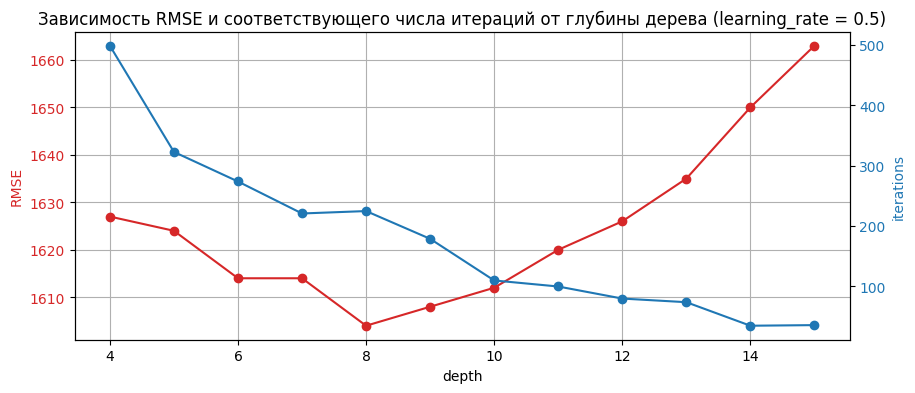

RMSE_min = 1604            при depth = 8,        числе итераций  225,        learning_rate = 0.5



CPU times: total: 1h 57min 33s
Wall time: 14min 32s


In [142]:
%%time
catboost_cv_grid(4,15,500,0.5)

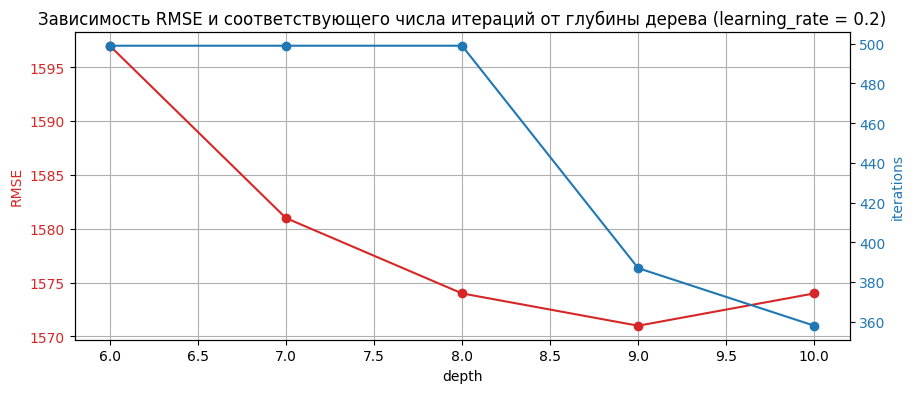

RMSE_min = 1571            при depth = 9,        числе итераций  387,        learning_rate = 0.2



CPU times: total: 1h 42min 13s
Wall time: 13min 47s


In [143]:
%%time
catboost_cv_grid(6,10,500,0.2)

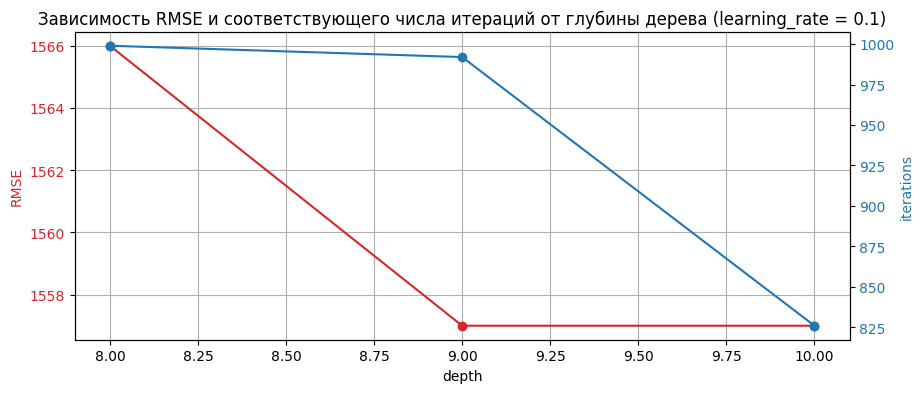

RMSE_min = 1557            при depth = 9,        числе итераций  992,        learning_rate = 0.1



CPU times: total: 2h 30min
Wall time: 19min 26s


In [144]:
%%time
catboost_cv_grid(8,10,1000,0.1)

### LightGBM

In [160]:
def light_gbm_cv(depth, iterations, learning_rate):
    '''с помощью кросс-валидации возвращает RMSE_min и номер итерации при RMSE_min; 
       на входе глубина дерева, максимальное кол-во итераций, learning_rate'''

    train_data = lgb.Dataset(f_tn_oe, label=t_tn, categorical_feature=col_cat)
    
    param = {'objective': 'regression',
             'metric': 'rmse',
             'learning_rate': learning_rate,
             'max_depth': depth,
             'num_leaves': 1000,
             'early_stopping_round': 10,
             'verbose': -1}
    scores = pd.DataFrame(lgb.cv(param, 
                                 train_data, 
                                 nfold=3,
                                 stratified=False,
                                 num_boost_round=iterations,
                                 categorical_feature = col_cat))
    return round(scores['rmse-mean'].min()), scores['rmse-mean'].idxmin()

In [161]:
def light_gbm_cv_grid(depth_min, depth_max, iterations, learning_rate):
    '''рисует диаграмму зависимости RMSE и числа итераций от глубины дерева;
       выдаёт df c перечнем RMSE_min и соответствующие depth с числом итераций;
       на входе min/max глубина дерева для перебора, максимальное число итераций, learning_rate'''
    rmse_df = pd.DataFrame(columns=['RMSE','n_iterations'])
    for depth in range(depth_min, depth_max+1):
        rmse_df = pd.concat([rmse_df,pd.DataFrame([light_gbm_cv(depth, iterations, learning_rate)], 
                                                  [depth], 
                                                  ['RMSE','n_iterations'])])
    plot_rmse_iter(rmse_df, learning_rate)

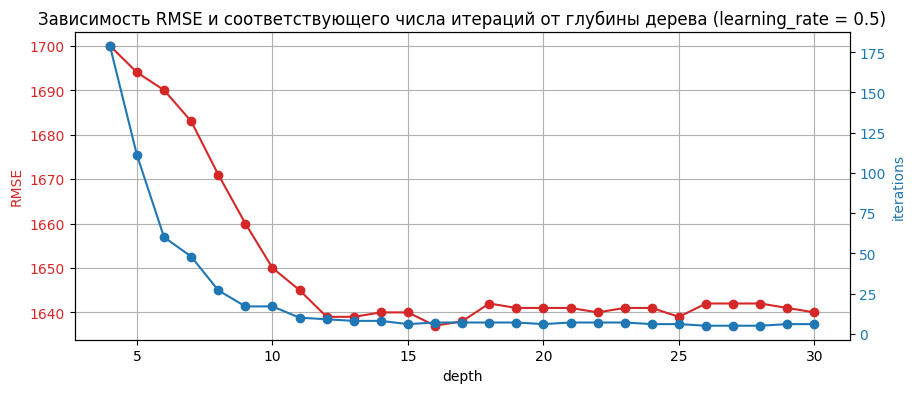

RMSE_min = 1637            при depth = 16,        числе итераций  7,        learning_rate = 0.5



CPU times: total: 3min 31s
Wall time: 2min


In [162]:
%%time
light_gbm_cv_grid(4,30,500,0.5)

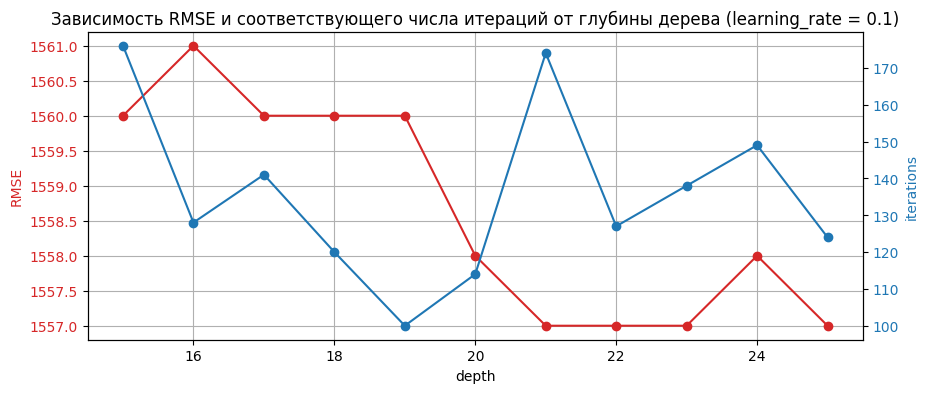

RMSE_min = 1557            при depth = 21,        числе итераций  174,        learning_rate = 0.1



CPU times: total: 11min 8s
Wall time: 7min 11s


In [163]:
%%time
light_gbm_cv_grid(15,25,500,0.1)

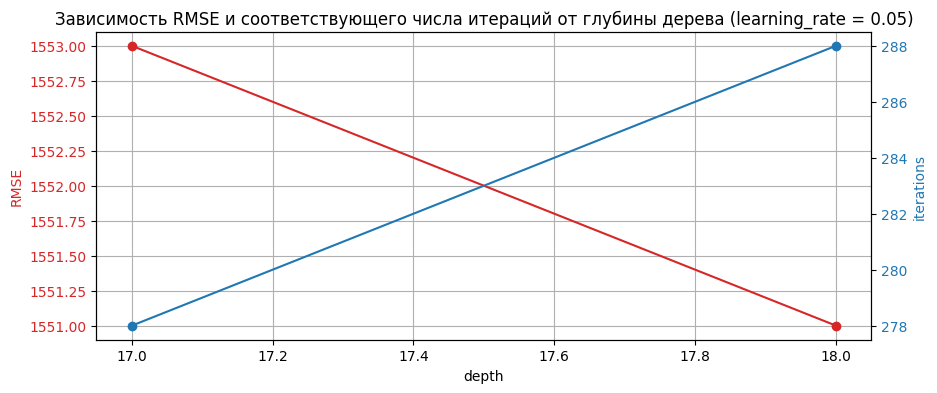

RMSE_min = 1551            при depth = 18,        числе итераций  288,        learning_rate = 0.05



CPU times: total: 3min 43s
Wall time: 2min 23s


In [164]:
%%time
light_gbm_cv_grid(17,18,500,0.05)

<a id= 'модели'></a>
## Анализ моделей

Модели обучались и тестировались на кросс-валидации. Таким образом время в таблице - это обучение и предсказание (в сумме).\
Число итераций в столбце время - это кол-во экспериментов во время подбора гиперпараметров.

| Модель | Гиперпараметры | Время | RMSE |
| --- | --- | --- | --- | 
| Linear regression (Ridge) | alpha=1 | 128 s<br>(12 min 45 s / 6)|  2456 |
| DecisionTreeRegressor | 'criterion': 'poisson', 'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 7 | 2 s<br> (2 h 26 min 23 s / 4860 итер.)| 1901 |
| RandomForestRegressor | 'criterion': 'poisson', 'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 100 | 263 s<br> (1 h 49 min 30 s / 25 итер.) | 1650 |
| RandomForestRegressor | 'criterion': 'poisson', 'max_depth': 24, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200 | 357 s<br> (59 min 36 s / 10 итер.) | 1645 |
| CatBoost |   depth: 8, n_iter: 225, learning_rate = 0.5 | 75 s<br> (15 min 1 s / 12 итер.)| 1604 |
| CatBoost |   depth: 9, n_iter: 387, learning_rate = 0.2 | 166 s<br> (13 min 50 s / 5 итер.)| 1571 |
| CatBoost |   depth: 9, n_iter: 992, learning_rate = 0.1 | 400 s<br> (20 min 1 s / 3 итер.)| 1557 |
| LightGBM |   depth: 16, n_iter: 7, learning_rate = 0.5 | 4 s<br> (2 min / 27 итер.)| 1637 |
| LightGBM |   depth: 21, n_iter: 174, learning_rate = 0.1 | 40 s<br> (7 min 15 s / 11 итер.)| 1557 |
| LightGBM |   depth: 18, n_iter: 288, learning_rate = 0.05 | 72 s<br> (2 min 22 s / 2 итер.)| 1551 |

Для производства выбираем модель LightGBM, показавшую наилучшее значение метрики и достаточно невысокое время.

## Проверка на тестовой выборке

In [168]:
%%time
train_data = lgb.Dataset(f_tn_oe, label=t_tn, categorical_feature=col_cat)
    
param = {'objective': 'regression',
         'learning_rate': 0.05,
         'max_depth': 18,
         'num_leaves': 1000}

model = lgb.train(param, 
                  train_data,
                  num_boost_round=288,
                  categorical_feature = col_cat)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3631
[LightGBM] [Info] Number of data points in the train set: 246693, number of used features: 11
[LightGBM] [Info] Start training from score 4570.742332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [169]:
%%time
prediction = model.predict(f_tt_oe)

CPU times: total: 9.14 s
Wall time: 808 ms


In [170]:
# RMSE на тестовой выборке
round(root_mean_squared_error(t_tt,prediction))

1519

<a id= 'вывод'></a>
## Вывод

Предобработка:
1. Размер исходного датасета 354369 объектов, 16 признаков. Отработано (заполнено, удалено) 181077 пропусков. Удалено 4 полных дубликата. Отработаны (исправвлены, удалены) выбросы. После всех отработок осталось 328924 объекта, т.е. удалено 7%.
2. По временнЫм столбцам DateCrawled, DateCreated, LastSeen удалено 189 объектов с выбросами; в RegistrationYear удалены 17974 объекта с выбросами; в RegistrationYear/Month - 7278 выбросов.
3. Медианные значения: Kilometer - 150000, Price - 2700, RegistrationYear - 2003, Power - 105 л.с.
4. NumberOfPictures - полностью удалён, т.к. содердит только 0.
5. В PostalCode уменьшено число уникальных значений на 2/3 из-за присвоения мало-популярным регионам значения 0.
6. Топ популярных брендов: volkswagen, opel, bmw, mercedes_benz, audi, ford.
7. Пропуски в Gearbox заполнены unknown; в FuelType - petrol; в Repaired - yes.

Анализ:
1. Наблюдаем корреляцию слабую отрицательную между Kilometer и Price, RegistrationYear; среднюю положительную между Price и Power, RegistrationYear (нелинейная "выпуклая" зависимость между RegistrationYear и Price); слабую положительную между Brand и Model.
2. Чем больше RegistrationYear (младше автомобиль) тем выше Power. При большей Power выше Kilometer.

Machine Learning:

1. Проведены эксперименты с 5-ю типами моделей (Linear regression,  DecisionTreeRegressor,  RandomForestRegressor, CatBoost,  LightGBM). Сводная таблица с результатами в разделе [Анализ моделей](#модели).<br> 
Лучший результат (RMSE=1549) на кросс-валидации показала модель LightGBM с гиперпараметрами depth 17, n_iter 371, learning_rate  0.05.  Время обучения и предсказания на кросс-валидации 77 секунд.
2. На тестовой выборке RMSE составляет 1519. Время обучения 28 с. Время предсказания 1 с.